### _NOTE:_ You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All". 


___
# Ioannou_Georgios


## Copyright © 2022 by Georgios Ioannou


___
<h1 align="center"> Voice Emotion Recognition of Audio </h1>
<h2 align="center"> Speech Emotion Recognition </h2>

In this notebook, we will be classifying emotion based on audio. The datasets we will be using are called:
1. [`RAVDESS Emotional speech audio`](https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-speech-audio/versions/1)
2. [`Crowd Sourced Emotional Multimodal Actors Dataset (CREMA-D)`](https://www.kaggle.com/datasets/ejlok1/cremad/versions/1)
3. [`Surrey Audio-Visual Expressed Emotion (SAVEE)`](https://www.kaggle.com/datasets/ejlok1/surrey-audiovisual-expressed-emotion-savee/versions/1)
4. [`Toronto emotional speech set (TESS)`](https://www.kaggle.com/datasets/ejlok1/toronto-emotional-speech-set-tess/versions/1)


___
<h2 align="center"> Remember our main steps motto "ISBE". </h2>

<h3 align="center"> Main Steps when building a Machine Learning Model. </h3>

1. <b>I</b> - Inspect and explore data.
2. <b>S</b> - Select and engineer features.
3. <b>B</b> - Build and train model.
4. <b>E</b> - Evaluate model.


___
<h2 align="center"> Libraries </h2>


In [7]:
# import libraries.

# Use inline so our visualizations display in notebook.


%matplotlib inline

import IPython
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
sns.set()
import warnings
warnings.filterwarnings('ignore')

# shows dependencies (used to update requirements.txt)
import session_info 

from keras.utils import np_utils
from keras.utils.np_utils import to_categorical
from plotly.subplots import make_subplots
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, multilabel_confusion_matrix, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import load_model
from tqdm.auto import tqdm


In [8]:
# run this everytime we add new imports
session_info.show()

___
## #1 Inspect and Explore Data


## 1.1 List All Files Under The Input Directory To See The File Paths


In [3]:
files_list = []
files_count = 0

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        files_list.append(os.path.join(dirname, filename))
        files_count += 1

# Remove the file /kaggle/input/videodemographics/VideoDemographics.csv as it is not an audio file.
files_list.remove('/kaggle/input/videodemographics/VideoDemographics.csv')

print('\nLength of files_list=', len(files_list))
print('files_list[0]=', files_list[0])
print('files_list[12161]=', files_list[12161])
print('files_count(audio files)=', files_count - 1)



Length of files_list= 12162
files_list[0]= /kaggle/input/cremad/AudioWAV/1028_TSI_DIS_XX.wav
files_list[12161]= /kaggle/input/surrey-audiovisual-expressed-emotion-savee/ALL/KL_h14.wav
files_count(audio files)= 12162


## 1.2 Import Datasets Paths

In [4]:
RAVDESS_PATH = '../input/ravdessemotionalspeechaudio'
CREMAD_PATH  = '../input/cremad/AudioWAV/'
SAVEE_PATH   = '../input/surrey-audiovisual-expressed-emotion-savee/ALL/'
TESS_PATH    = '../input/torontoemotionalspeechsettess'


## 1.3 Prepare the data of the RAVDESS Dataset


In [5]:
# Accessing inner files.
# List comprehension gets rid of hidden files.
ravdess_dir_list = [x for x in os.listdir(RAVDESS_PATH) if not x.startswith('.')]
print('Ravdess:\n', sorted(ravdess_dir_list))


Ravdess:
 ['Actor_01', 'Actor_02', 'Actor_03', 'Actor_04', 'Actor_05', 'Actor_06', 'Actor_07', 'Actor_08', 'Actor_09', 'Actor_10', 'Actor_11', 'Actor_12', 'Actor_13', 'Actor_14', 'Actor_15', 'Actor_16', 'Actor_17', 'Actor_18', 'Actor_19', 'Actor_20', 'Actor_21', 'Actor_22', 'Actor_23', 'Actor_24']


In [6]:
# Create df columns.
emotion = []
gender = []
location = []

# Iterate over inner folders.
for actor_file in ravdess_dir_list:
    actor_wavs = [x for x in os.listdir(RAVDESS_PATH + '/' + actor_file) if not x.startswith('.')]
    # Iterate over .wav files.
    for wav in actor_wavs:
        partition = wav.split('-')
        emotion_num = int(partition[2])
        
        emotion.append(emotion_num)
        actor_num = int(partition[6].split('.')[0])
        
        if (actor_num%2 == 0): gender.append('female')
        else: gender.append('male')
        
        location.append(RAVDESS_PATH + '/' + actor_file + '/' + wav)

# Initialize dataframe.
ravdess_df = pd.DataFrame({'gender': gender, 'emotion': emotion, 'location': location },
                          columns=['gender','emotion', 'location'])

# Swap numerical value to label.
ravdess_df = ravdess_df.replace({"emotion": {1:'neutral', 2:'calm', 3:'happy', 4:'sad',
                                5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}})

print('ravdess_df.shape=', ravdess_df.shape, '\n')
print('Unique emotions = ', ravdess_df['emotion'].unique(), '\n')
print('# of Unique emotions = ', len(ravdess_df['emotion'].unique()), '\n')
print(ravdess_df.emotion.value_counts(), '\n')
ravdess_df


ravdess_df.shape= (1440, 3) 

Unique emotions =  ['surprise' 'neutral' 'disgust' 'fear' 'sad' 'calm' 'happy' 'angry'] 

# of Unique emotions =  8 

surprise    192
disgust     192
fear        192
sad         192
calm        192
happy       192
angry       192
neutral      96
Name: emotion, dtype: int64 



gender   emotion                                           location
0     female  surprise  ../input/ravdessemotionalspeechaudio/Actor_02/...
1     female   neutral  ../input/ravdessemotionalspeechaudio/Actor_02/...
2     female   disgust  ../input/ravdessemotionalspeechaudio/Actor_02/...
3     female   disgust  ../input/ravdessemotionalspeechaudio/Actor_02/...
4     female   neutral  ../input/ravdessemotionalspeechaudio/Actor_02/...
...      ...       ...                                                ...
1435    male      fear  ../input/ravdessemotionalspeechaudio/Actor_07/...
1436    male     angry  ../input/ravdessemotionalspeechaudio/Actor_07/...
1437    male       sad  ../input/ravdessemotionalspeechaudio/Actor_07/...
1438    male   disgust  ../input/ravdessemotionalspeechaudio/Actor_07/...
1439    male     angry  ../input/ravdessemotionalspeechaudio/Actor_07/...

[1440 rows x 3 columns]

## 1.4 Prepare the data of the CREMA-D Dataset


In [7]:
# Creating dictionary from CREMA github documentation on actors' gender
Crema_genders = pd.read_csv('../input/videodemographics/VideoDemographics.csv')
select_cond = ['ActorID', 'Sex']

# Looks like this: {1001: 'female'}
extraction = Crema_genders[select_cond]
extraction_dict = dict(extraction.values)


# Processing CREMA Dataset

emotion = []
intensity = []
gender = []
location = []

wavs = [x for x in os.listdir(CREMAD_PATH) if not x.startswith('.')]

for wav in wavs:
    partition = wav.split('_')
    emotion_ = partition[2]
    intensity_ = partition[3].split('.')[0]
    actor_ID = int(partition[0])
    
    # looks up the dictionary made in prev cell
    if actor_ID in extraction_dict: gender.append(extraction_dict.get(actor_ID))
    
    intensity.append(intensity_)
    emotion.append(emotion_) 
    location.append(CREMAD_PATH + '/' + wav)

crema_df = pd.DataFrame({'gender': gender, 'emotion': emotion, 'location': location}, 
                        columns=['gender','emotion', 'location'])

crema_df = crema_df.replace({'emotion': {'ANG':'angry','DIS': 'disgust',
                                        'FEA': 'fear','HAP': 'happy',
                                        'NEU': 'neutral','SAD': 'sad'}})

crema_df = crema_df.replace({'intensity': {'LO': 'low','MD': 'medium',
                                            'HI': 'high','XX': 'unspecified'}})                           

print('crema_df.shape=', crema_df.shape, '\n')
print('Unique emotions = ', crema_df['emotion'].unique(), '\n')
print('# of Unique emotions = ', len(crema_df['emotion'].unique()), '\n')
print(crema_df.emotion.value_counts(), '\n')
crema_df


crema_df.shape= (7442, 3) 

Unique emotions =  ['disgust' 'happy' 'sad' 'neutral' 'fear' 'angry'] 

# of Unique emotions =  6 

disgust    1271
happy      1271
sad        1271
fear       1271
angry      1271
neutral    1087
Name: emotion, dtype: int64 



gender  emotion                                       location
0     Female  disgust  ../input/cremad/AudioWAV//1028_TSI_DIS_XX.wav
1     Female    happy  ../input/cremad/AudioWAV//1075_IEO_HAP_LO.wav
2     Female    happy  ../input/cremad/AudioWAV//1084_ITS_HAP_XX.wav
3       Male  disgust  ../input/cremad/AudioWAV//1067_IWW_DIS_XX.wav
4       Male  disgust  ../input/cremad/AudioWAV//1066_TIE_DIS_XX.wav
...      ...      ...                                            ...
7437  Female    angry  ../input/cremad/AudioWAV//1060_IEO_ANG_MD.wav
7438    Male    angry  ../input/cremad/AudioWAV//1088_IWL_ANG_XX.wav
7439    Male    angry  ../input/cremad/AudioWAV//1050_IOM_ANG_XX.wav
7440    Male      sad  ../input/cremad/AudioWAV//1044_IWL_SAD_XX.wav
7441  Female      sad  ../input/cremad/AudioWAV//1009_ITH_SAD_XX.wav

[7442 rows x 3 columns]

## 1.5 Prepare the data of the SAVEE Dataset


In [8]:
location = []
gender = []
emotion = []

wavs = [x for x in os.listdir(SAVEE_PATH) if not x.startswith('.')]

for wav in wavs:
    partition = wav.split('_')
    emotion_ = partition[1].split('.')[0]
    emotion_ = ''.join(i for i in emotion_ if not i.isdigit())
    
    emotion.append(emotion_)
    gender.append('male')
    location.append(SAVEE_PATH + '/' + wav)

savee_df = pd.DataFrame({'gender': gender, 'emotion': emotion, 'location': location},
                        columns=['gender','emotion','location'])

savee_df = savee_df.replace({'emotion': {'a':'angry','d': 'disgust','f': 'fear','h': 'happy',
                                         'n': 'neutral','sa': 'sad', 'su': 'surprise'}})
print('savee_df.shape=', savee_df.shape, '\n')
print('Unique emotions = ', savee_df['emotion'].unique(), '\n')
print('# of Unique emotions = ', len(savee_df['emotion'].unique()), '\n')
print(savee_df.emotion.value_counts(), '\n')
savee_df


savee_df.shape= (480, 3) 

Unique emotions =  ['happy' 'fear' 'disgust' 'angry' 'surprise' 'neutral' 'sad'] 

# of Unique emotions =  7 

neutral     120
happy        60
fear         60
disgust      60
angry        60
surprise     60
sad          60
Name: emotion, dtype: int64 



gender   emotion                                           location
0     male     happy  ../input/surrey-audiovisual-expressed-emotion-...
1     male      fear  ../input/surrey-audiovisual-expressed-emotion-...
2     male     happy  ../input/surrey-audiovisual-expressed-emotion-...
3     male   disgust  ../input/surrey-audiovisual-expressed-emotion-...
4     male     angry  ../input/surrey-audiovisual-expressed-emotion-...
..     ...       ...                                                ...
475   male  surprise  ../input/surrey-audiovisual-expressed-emotion-...
476   male   neutral  ../input/surrey-audiovisual-expressed-emotion-...
477   male   neutral  ../input/surrey-audiovisual-expressed-emotion-...
478   male     angry  ../input/surrey-audiovisual-expressed-emotion-...
479   male     happy  ../input/surrey-audiovisual-expressed-emotion-...

[480 rows x 3 columns]

## 1.6 Prepare the data of the TESS Dataset


In [9]:
# Accessing inner files.
# List comprehension gets rid of hidden files.
tess_dir_list = [x for x in os.listdir(TESS_PATH) if not x.startswith('.')]
print('Tess:\n', sorted(tess_dir_list))


Tess:
 ['OAF_Fear', 'OAF_Pleasant_surprise', 'OAF_Sad', 'OAF_angry', 'OAF_disgust', 'OAF_happy', 'OAF_neutral', 'YAF_angry', 'YAF_disgust', 'YAF_fear', 'YAF_happy', 'YAF_neutral', 'YAF_pleasant_surprised', 'YAF_sad']


In [10]:
# Create df columns.
emotion = []
gender = []
location = []

# Iterate over inner folders.
for actor_file in tess_dir_list:
    actor_wavs = [x for x in os.listdir(TESS_PATH + '/' + actor_file) if not x.startswith('.')]
    
    # Iterate over .wav files
    for wav in actor_wavs:
        partition = actor_wavs[0].split('_')
        emotion_ = partition[2].split('.')[0]
        emotion.append(emotion_)
        gender.append('female')
        location.append(TESS_PATH + '/' + actor_file + '/' + wav)

# Initializing dataframe.
tess_df = pd.DataFrame({'gender': gender, 'emotion': emotion, 'location': location },
                       columns=['gender','emotion','location'])

# Swapping 'ps' to 'pleasant surprise'.
tess_df = tess_df.replace({'emotion': {'ps':'pleasant surprise'}})

print('tess_df.shape=', tess_df.shape, '\n')
print('Unique emotions = ', tess_df['emotion'].unique(), '\n')
print('# of Unique emotions = ', len(tess_df['emotion'].unique()), '\n')
print(tess_df.emotion.value_counts(), '\n')
tess_df


tess_df.shape= (2800, 3) 

Unique emotions =  ['fear' 'angry' 'disgust' 'neutral' 'sad' 'pleasant surprise' 'happy'] 

# of Unique emotions =  7 

fear                 400
angry                400
disgust              400
neutral              400
sad                  400
pleasant surprise    400
happy                400
Name: emotion, dtype: int64 



gender            emotion  \
0     female               fear   
1     female               fear   
2     female               fear   
3     female               fear   
4     female               fear   
...      ...                ...   
2795  female  pleasant surprise   
2796  female  pleasant surprise   
2797  female  pleasant surprise   
2798  female  pleasant surprise   
2799  female  pleasant surprise   

                                               location  
0     ../input/torontoemotionalspeechsettess/YAF_fea...  
1     ../input/torontoemotionalspeechsettess/YAF_fea...  
2     ../input/torontoemotionalspeechsettess/YAF_fea...  
3     ../input/torontoemotionalspeechsettess/YAF_fea...  
4     ../input/torontoemotionalspeechsettess/YAF_fea...  
...                                                 ...  
2795  ../input/torontoemotionalspeechsettess/YAF_ple...  
2796  ../input/torontoemotionalspeechsettess/YAF_ple...  
2797  ../input/torontoemotionalspeechsettess/YAF_ple...  
2798  ../input/torontoemotionalspeechsettess/YAF_ple...  
2799  ../input/torontoemotionalspeechsettess/YAF_ple...  

[2800 rows x 3 columns]

## 1.7 Merge All Dataframes To One Dataframe

In [11]:
comb_df=pd.concat([ravdess_df, crema_df, savee_df, tess_df],axis=0)

print('main_df.shape=', comb_df.shape, '\n')

print('Unique emotions = ', comb_df['emotion'].unique(), '\n')
print('# of Unique emotions = ', len(comb_df['emotion'].unique()), '\n')

print('Unique genders = ', comb_df['gender'].unique(), '\n')
print('# of Unique genders = ', len(comb_df['gender'].unique()), '\n')

print(comb_df.emotion.value_counts(), '\n')

print(comb_df.gender.value_counts(), '\n')


comb_df


main_df.shape= (12162, 3) 

Unique emotions =  ['surprise' 'neutral' 'disgust' 'fear' 'sad' 'calm' 'happy' 'angry'
 'pleasant surprise'] 

# of Unique emotions =  9 

Unique genders =  ['female' 'male' 'Female' 'Male'] 

# of Unique genders =  4 

disgust              1923
fear                 1923
sad                  1923
happy                1923
angry                1923
neutral              1703
pleasant surprise     400
surprise              252
calm                  192
Name: emotion, dtype: int64 

Male      3930
female    3520
Female    3512
male      1200
Name: gender, dtype: int64 



gender            emotion  \
0     female           surprise   
1     female            neutral   
2     female            disgust   
3     female            disgust   
4     female            neutral   
...      ...                ...   
2795  female  pleasant surprise   
2796  female  pleasant surprise   
2797  female  pleasant surprise   
2798  female  pleasant surprise   
2799  female  pleasant surprise   

                                               location  
0     ../input/ravdessemotionalspeechaudio/Actor_02/...  
1     ../input/ravdessemotionalspeechaudio/Actor_02/...  
2     ../input/ravdessemotionalspeechaudio/Actor_02/...  
3     ../input/ravdessemotionalspeechaudio/Actor_02/...  
4     ../input/ravdessemotionalspeechaudio/Actor_02/...  
...                                                 ...  
2795  ../input/torontoemotionalspeechsettess/YAF_ple...  
2796  ../input/torontoemotionalspeechsettess/YAF_ple...  
2797  ../input/torontoemotionalspeechsettess/YAF_ple...  
2798  ../input/torontoemotionalspeechsettess/YAF_ple...  
2799  ../input/torontoemotionalspeechsettess/YAF_ple...  

[12162 rows x 3 columns]

## 1.8 Replace Redundant Data

In [12]:
# Replace 'Female' with 'female'
comb_df['gender'] = comb_df['gender'].replace('Female', 'female')

# Replace 'Male' with 'male'
comb_df['gender'] = comb_df['gender'].replace('Male', 'male')

# Replace 'pleasant surprise' with 'surprise'
comb_df['emotion'] = comb_df['emotion'].replace('pleasant surprise', 'surprise')


print('main_df.shape=', comb_df.shape, '\n')

print('Unique emotions = ', comb_df['emotion'].unique(), '\n')
print('# of Unique emotions = ', len(comb_df['emotion'].unique()), '\n')

print('Unique genders = ', comb_df['gender'].unique(), '\n')
print('# of Unique genders = ', len(comb_df['gender'].unique()), '\n')

print(comb_df.emotion.value_counts(), '\n')

print(comb_df.gender.value_counts(), '\n')


comb_df


main_df.shape= (12162, 3) 

Unique emotions =  ['surprise' 'neutral' 'disgust' 'fear' 'sad' 'calm' 'happy' 'angry'] 

# of Unique emotions =  8 

Unique genders =  ['female' 'male'] 

# of Unique genders =  2 

disgust     1923
fear        1923
sad         1923
happy       1923
angry       1923
neutral     1703
surprise     652
calm         192
Name: emotion, dtype: int64 

female    7032
male      5130
Name: gender, dtype: int64 



gender   emotion                                           location
0     female  surprise  ../input/ravdessemotionalspeechaudio/Actor_02/...
1     female   neutral  ../input/ravdessemotionalspeechaudio/Actor_02/...
2     female   disgust  ../input/ravdessemotionalspeechaudio/Actor_02/...
3     female   disgust  ../input/ravdessemotionalspeechaudio/Actor_02/...
4     female   neutral  ../input/ravdessemotionalspeechaudio/Actor_02/...
...      ...       ...                                                ...
2795  female  surprise  ../input/torontoemotionalspeechsettess/YAF_ple...
2796  female  surprise  ../input/torontoemotionalspeechsettess/YAF_ple...
2797  female  surprise  ../input/torontoemotionalspeechsettess/YAF_ple...
2798  female  surprise  ../input/torontoemotionalspeechsettess/YAF_ple...
2799  female  surprise  ../input/torontoemotionalspeechsettess/YAF_ple...

[12162 rows x 3 columns]

## 1.9 Inspect / Remove null Values


In [13]:
print(comb_df.isnull().sum())
print()
print('comb_df.isnull().sum().sum() = ', comb_df.isnull().sum().sum())


gender      0
emotion     0
location    0
dtype: int64

comb_df.isnull().sum().sum() =  0


## 1.10 Inspect / Remove Duplicate Rows


In [14]:
print('comb_df.duplicated().sum() = ', comb_df.duplicated().sum())


comb_df.duplicated().sum() =  0


## 1.11 Print Out The Number Examples In Each Class (aka the class balances)


In [15]:
comb_df.emotion.value_counts(), comb_df.emotion.value_counts(normalize=True)


(disgust     1923
 fear        1923
 sad         1923
 happy       1923
 angry       1923
 neutral     1703
 surprise     652
 calm         192
 Name: emotion, dtype: int64,
 disgust     0.158115
 fear        0.158115
 sad         0.158115
 happy       0.158115
 angry       0.158115
 neutral     0.140026
 surprise    0.053610
 calm        0.015787
 Name: emotion, dtype: float64)

## 1.12 Print Out The Number Of Unique Emotions


In [16]:
emotions_classes = comb_df['emotion'].unique()
print(emotions_classes)


['surprise' 'neutral' 'disgust' 'fear' 'sad' 'calm' 'happy' 'angry']


## 1.13 Bar Graph and Pie Chart Of The Unique Emotions


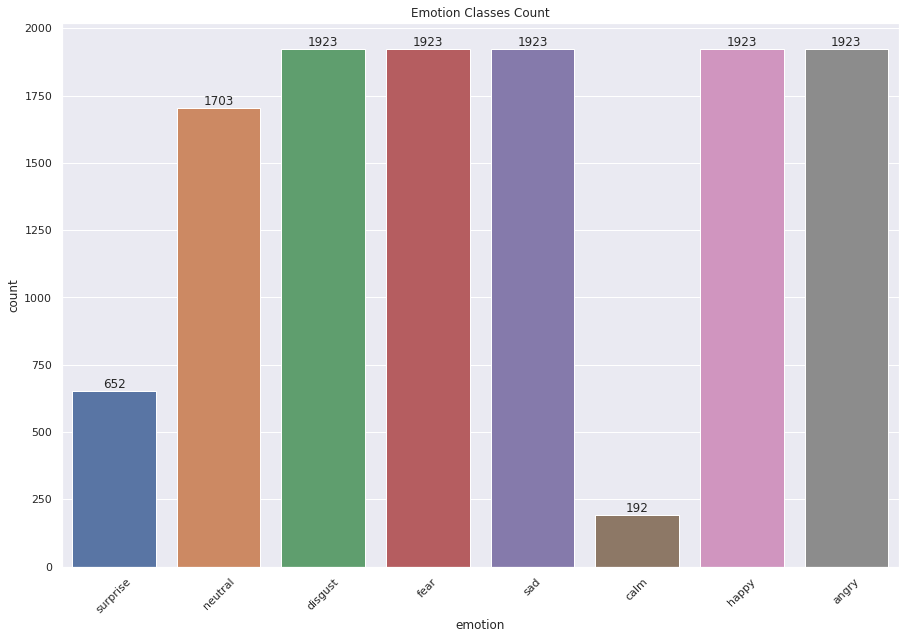

In [17]:
plt.figure(figsize = (15,10))
plt.title('Emotion Classes Count')
emotions = sns.countplot(x = 'emotion',data = comb_df)
emotions.set_xticklabels(emotions.get_xticklabels(),rotation = 45)
ax = sns.countplot(x = 'emotion', data = comb_df)
ax.bar_label(ax.containers[0])
plt.show()


In [18]:
fig = px.bar(data_frame = comb_df,
             x = comb_df['emotion'].value_counts().index,
             y = comb_df['emotion'].value_counts(),
             color = comb_df['emotion'].value_counts().index,
             labels={'x':'emotion', 'y':'count'},
             title = 'Emotion Classes Count')
fig.show()


In [19]:
comb_df['emotion'].value_counts()

labels = comb_df['emotion'].value_counts().index
values = comb_df['emotion'].value_counts().values
colors=['Lightskyblue']

fig = go.Figure(data=[go.Pie(labels = labels, values = values, textinfo = 'label+percent',
                             insidetextorientation = 'radial',marker = dict(colors = colors))])

fig.update_layout(title='Emotion Classes Counts')
fig.show()


## 1.14 Bar Graph and Pie Chart Of The Unique Genders


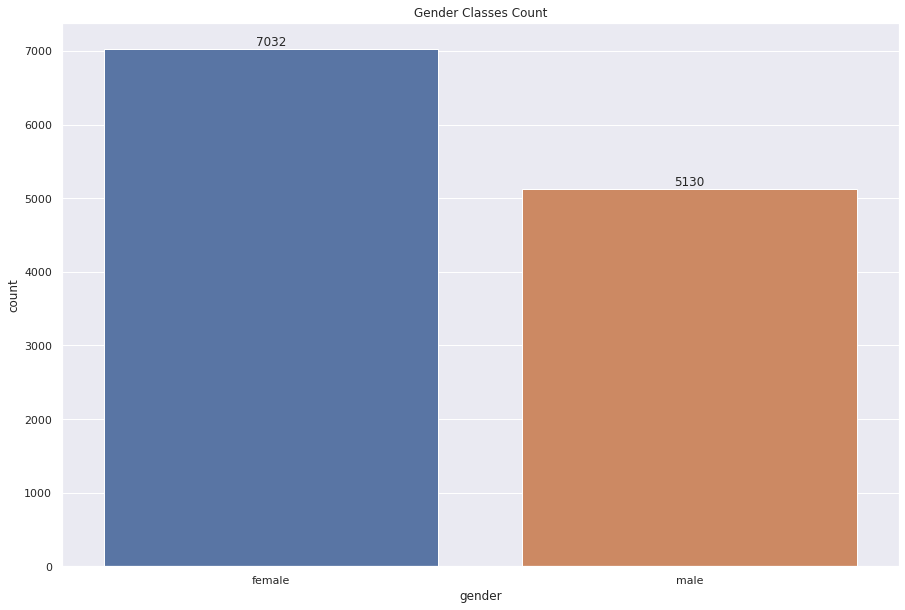

In [20]:
plt.figure(figsize = (15,10))
plt.title('Gender Classes Count')
genders = sns.countplot(x = 'gender',data = comb_df)
genders.set_xticklabels(genders.get_xticklabels())
ax = sns.countplot(x = 'gender', data = comb_df)
ax.bar_label(ax.containers[0])
plt.show()


In [21]:
fig = px.bar(data_frame = comb_df,
             x = comb_df['gender'].value_counts().index,
             y = comb_df['gender'].value_counts(),
             color = comb_df['gender'].value_counts().index,
             labels={'x':'gender', 'y':'count'},
             title = 'Gender Classes Count',
             width = 1240,
             height = 700)
fig.show()


In [22]:
comb_df['gender'].value_counts()

labels = comb_df['gender'].value_counts().index
values = comb_df['gender'].value_counts().values
colors = ['Red']

fig = go.Figure(data = [go.Pie(labels = labels, values = values, textinfo = 'label+percent',
                             insidetextorientation = 'radial',marker = dict(colors = colors))])
fig.update_layout(title = 'Gender Classes Counts')
fig.show()


## 1.15 Set Color For Each Emotion


In [23]:
emotion_colors = {'surprise':'#19d3f3',
                'neutral':'#ffa15a',
                'disgust':'#87cefa',
                'fear':'#636efa',
                'sad':'#ef553b',
                'calm':'#ff6692',
                'happy':'#00cc96',
                'angry':'#ab63fa'}


## 1.16 Wave Plot For Each Emotion


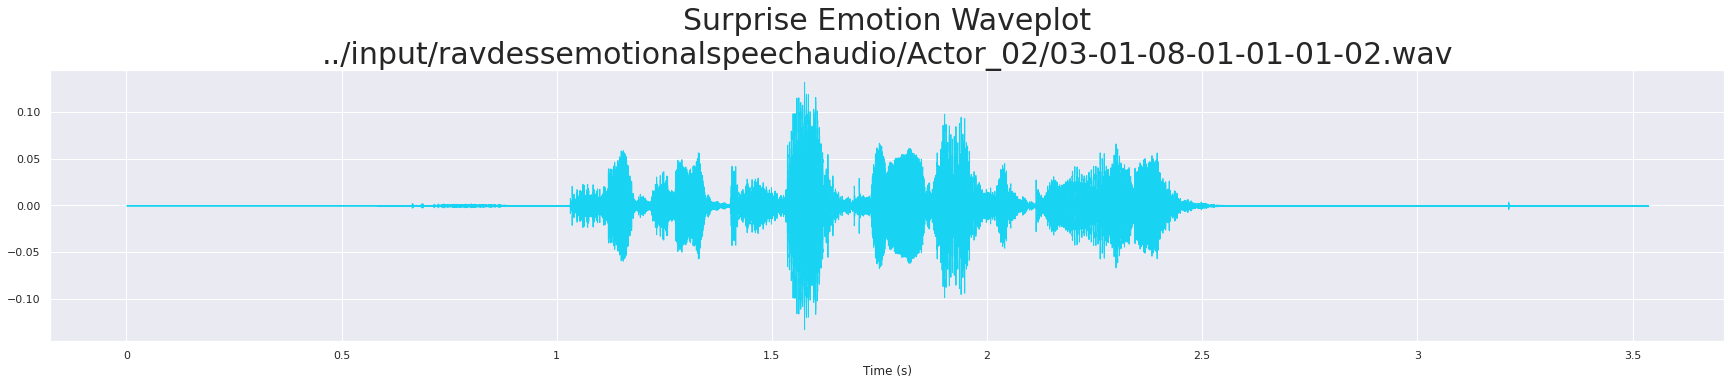

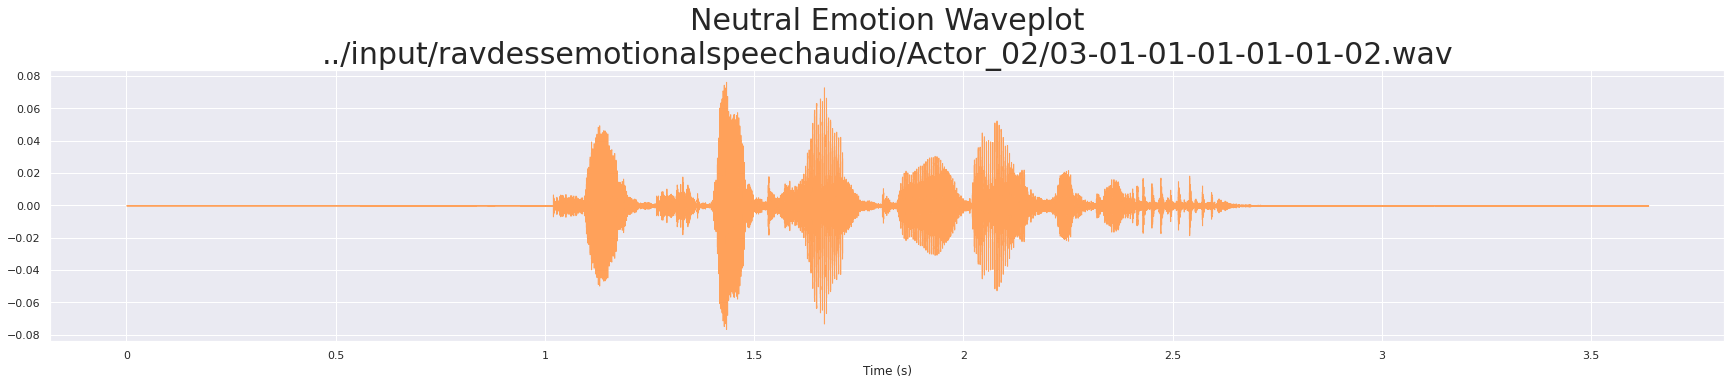

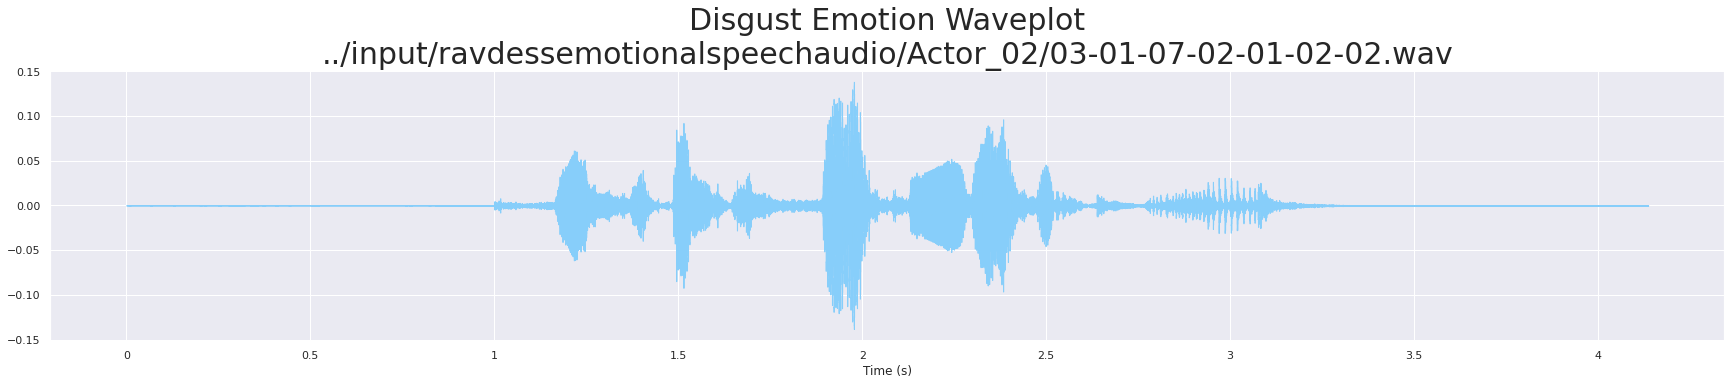

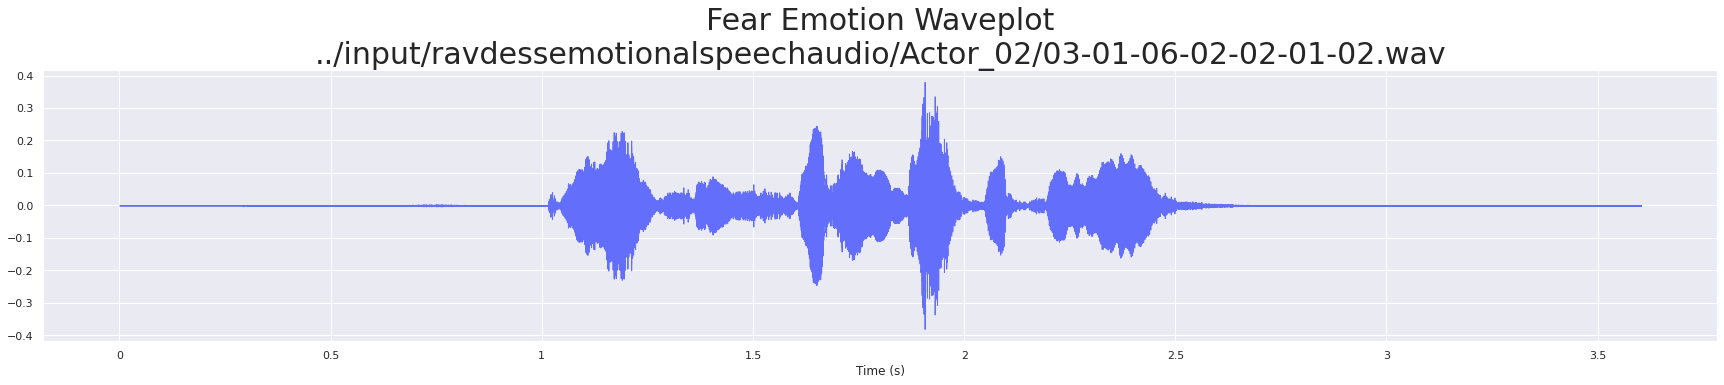

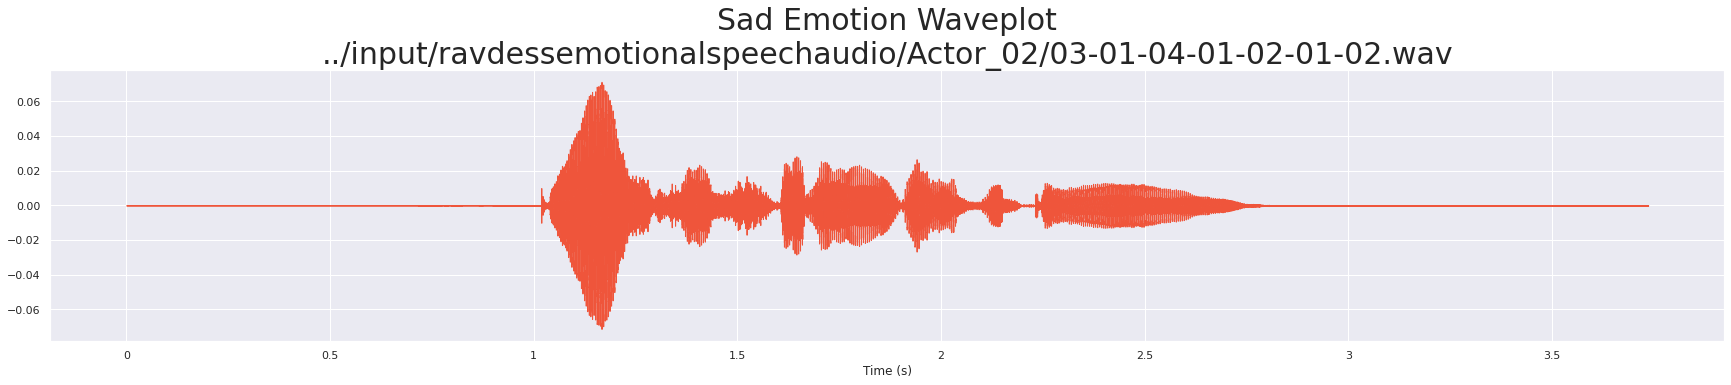

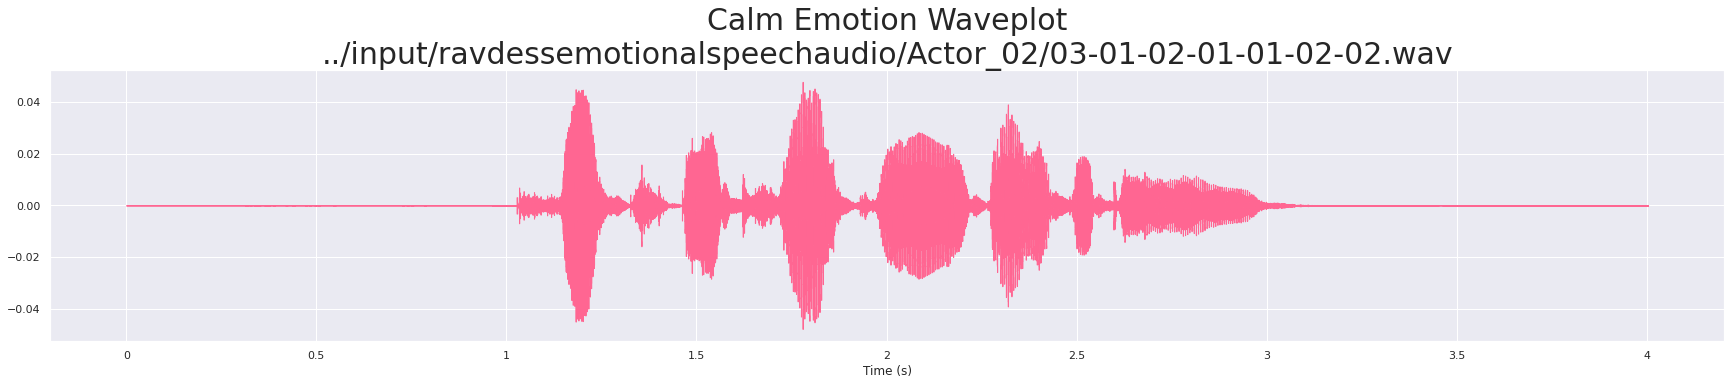

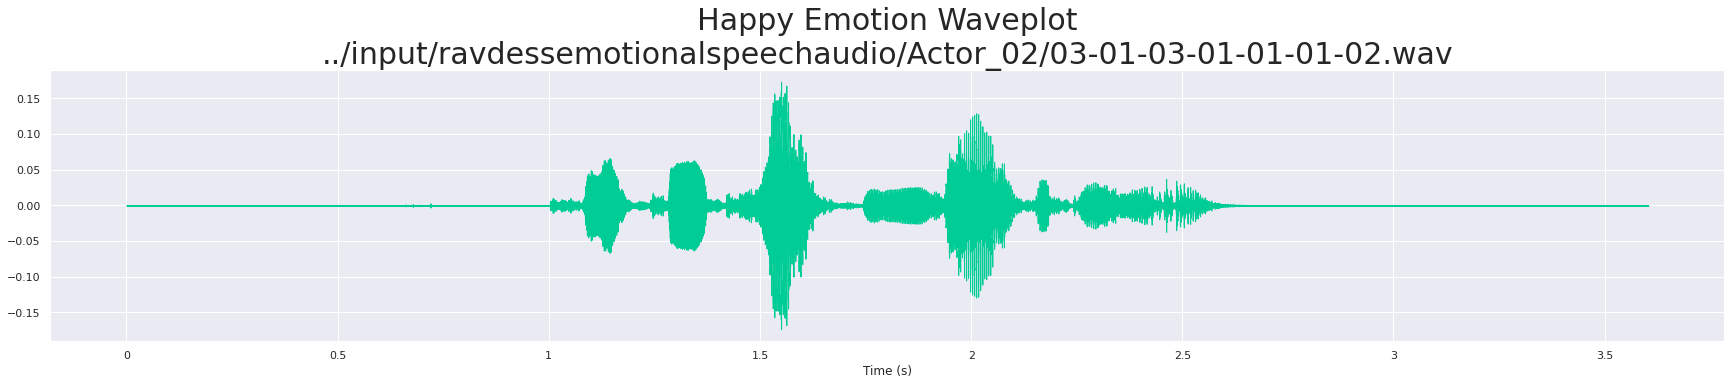

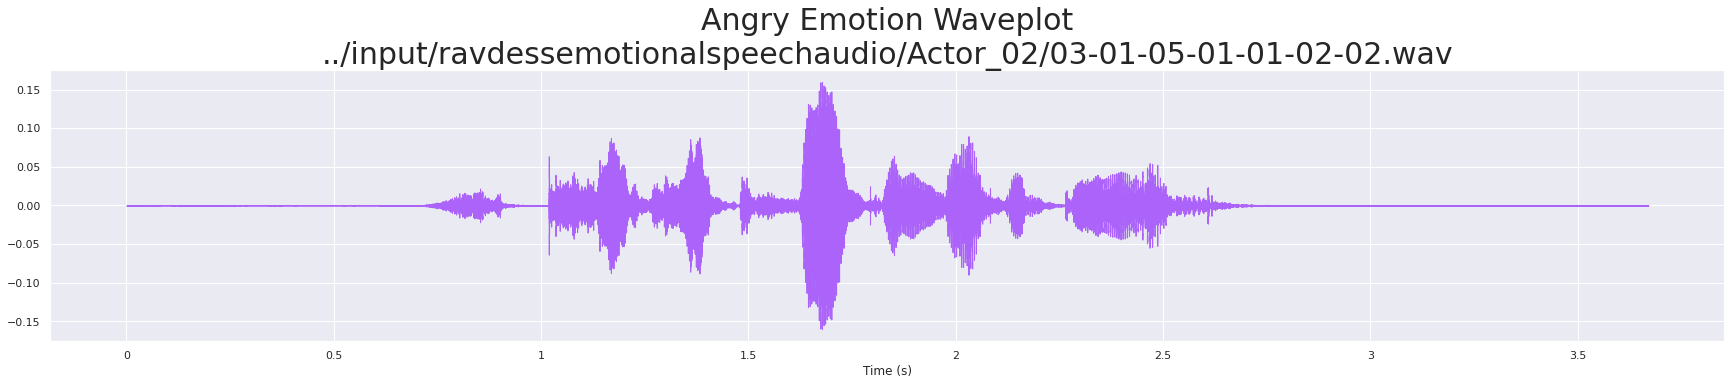

In [24]:
def wave_plot(audio_time_series, sampling_rate, emotion_class, emotion_color, file_path):
    plt.figure(figsize = (30, 5))
    librosa.display.waveshow(y = audio_time_series,sr = sampling_rate,color = emotion_color, x_axis = 's')
    plt.title(f'{emotion_class.capitalize()} Emotion Waveplot\n{file_path}', size = 30)


audio_path=[]
for emotion_class in emotions_classes:
    file_path = np.array(comb_df['location'][comb_df['emotion'] == emotion_class])[0]
    audio_time_series,sampling_rate = librosa.load(file_path)
    wave_plot(audio_time_series, sampling_rate, emotion_class, emotion_colors[emotion_class], file_path)


## 1.17 Spectogram For Each Emotion


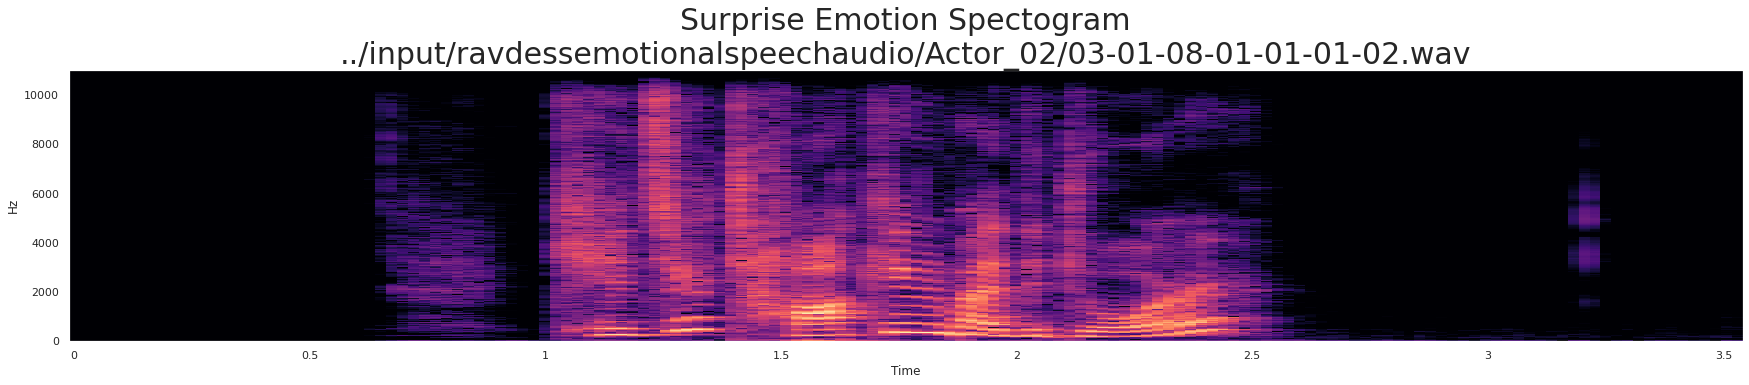

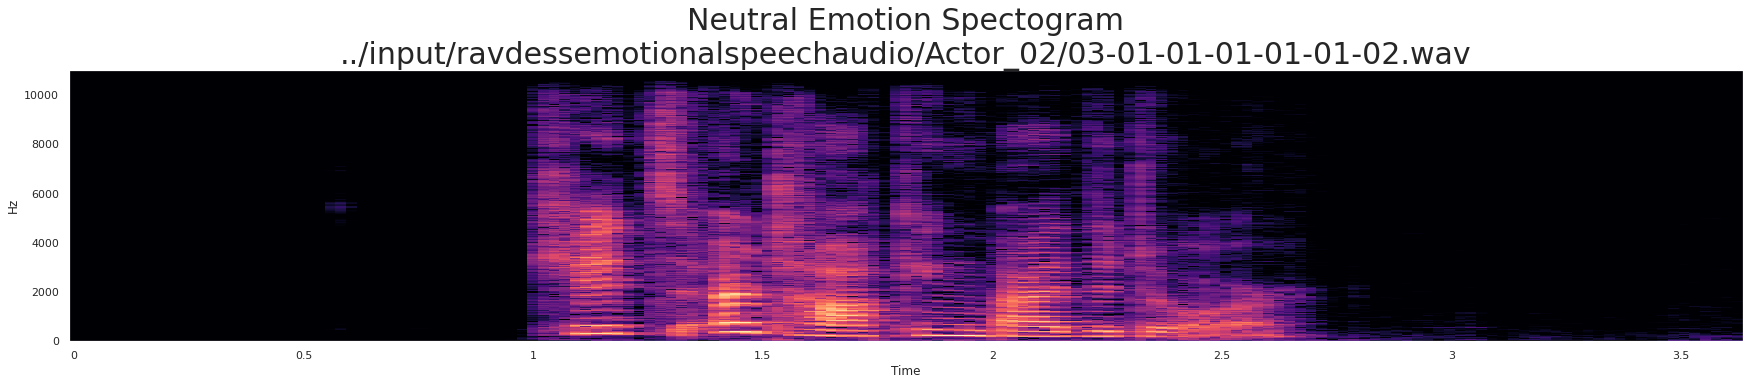

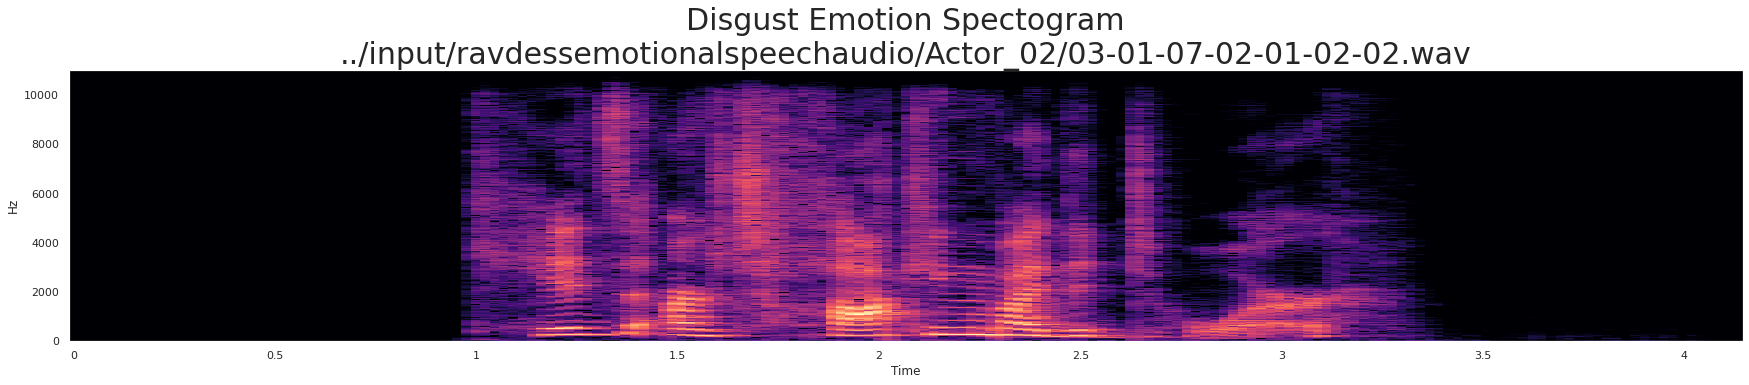

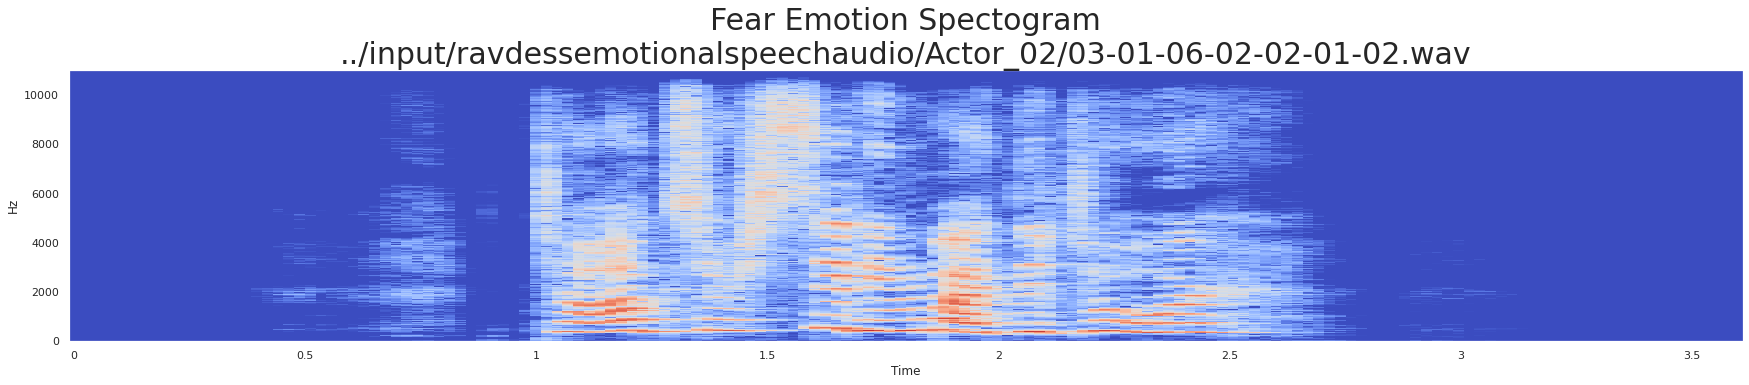

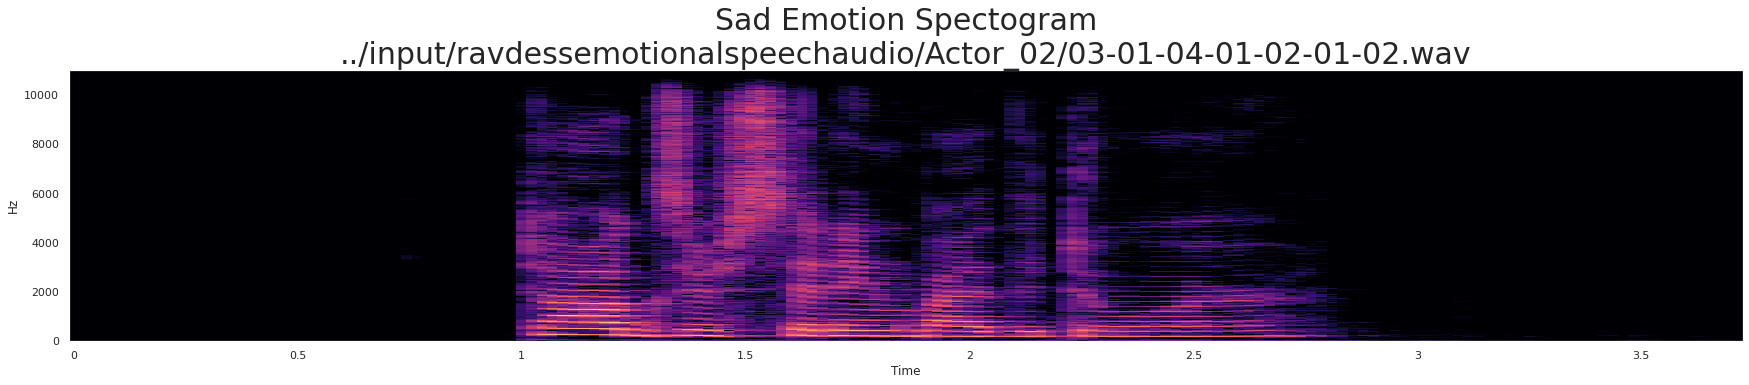

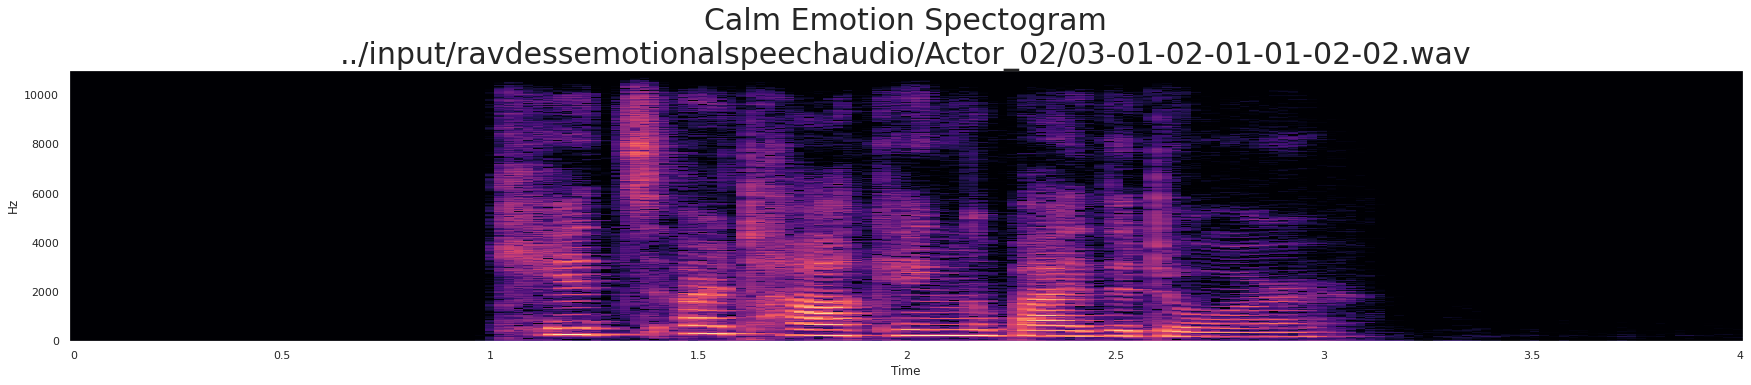

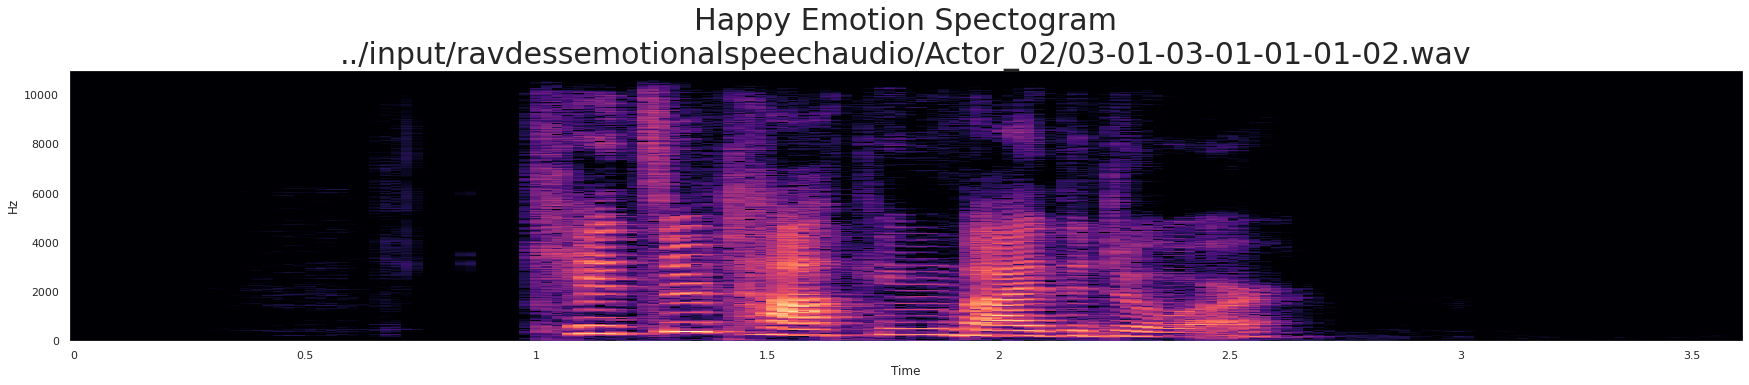

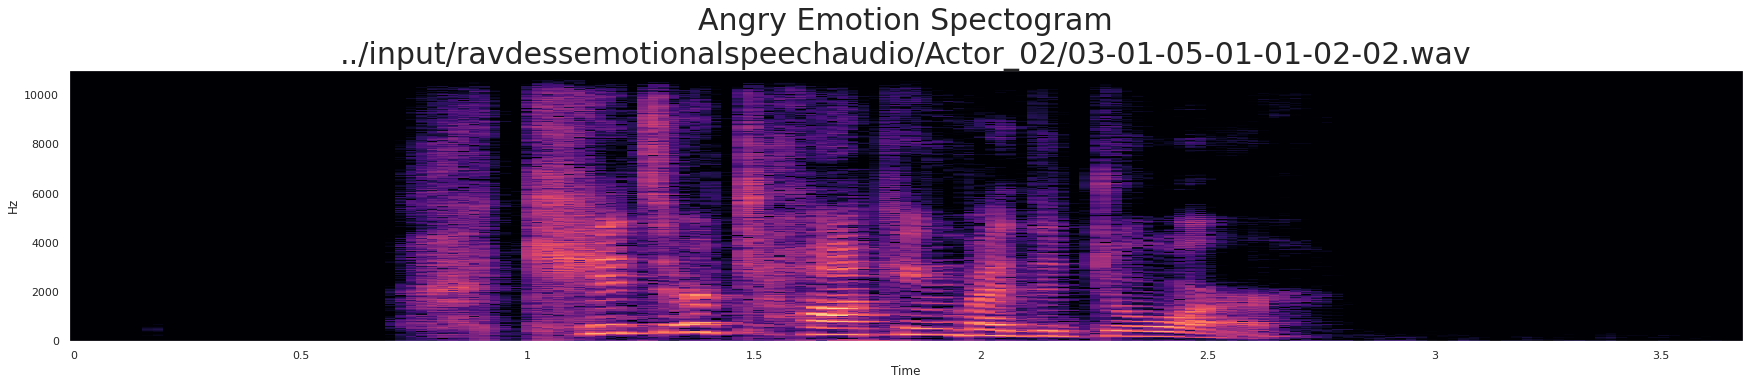

In [25]:
def spectogram(audio_time_series, sampling_rate, emotion_class, file_path):
    audio = librosa.stft(audio_time_series)
    audio_db = librosa.amplitude_to_db(abs(audio))
    plt.figure(figsize = (30,5))
    plt.title(f'{emotion_class.capitalize()} Emotion Spectogram\n{file_path}',size = 30)
    librosa.display.specshow(audio_db, sr = sampling_rate, x_axis = 'time', y_axis = 'hz')


audio_path=[]
for emotion_class in emotions_classes:
    file_path = np.array(comb_df['location'][comb_df['emotion'] == emotion_class])[0]
    audio_time_series, sampling_rate = librosa.load(file_path)
    spectogram(audio_time_series, sampling_rate, emotion_class, file_path)


## 1.18 Mel Spectogram For Each Emotion


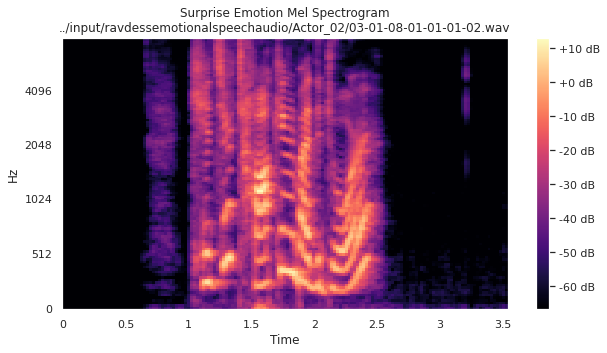

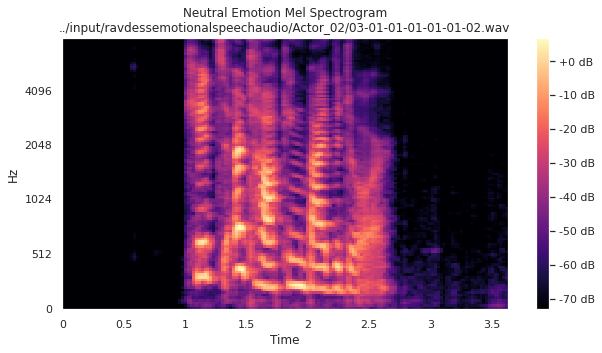

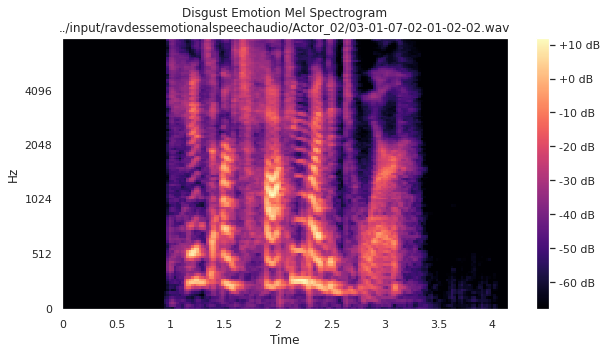

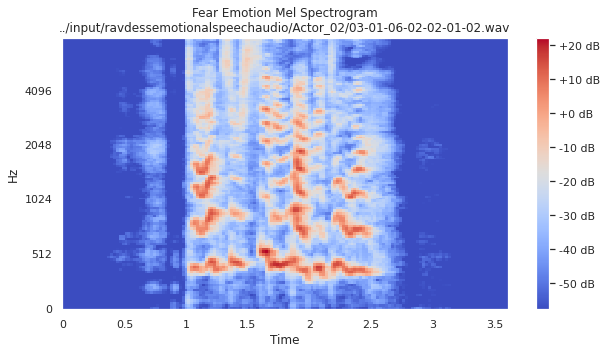

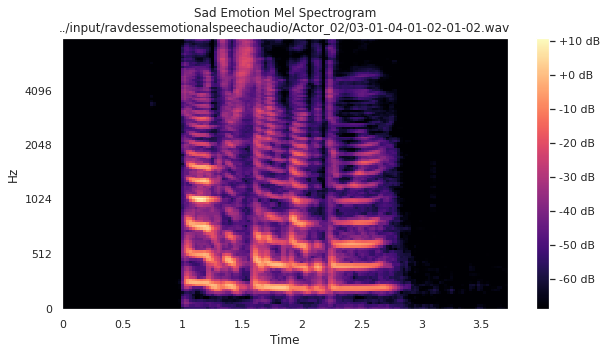

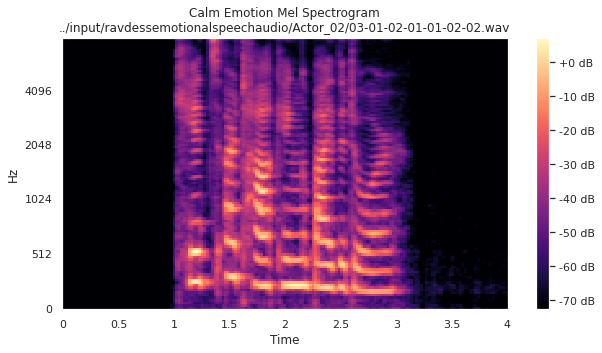

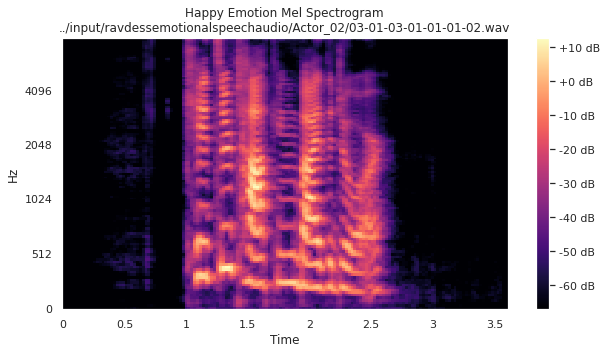

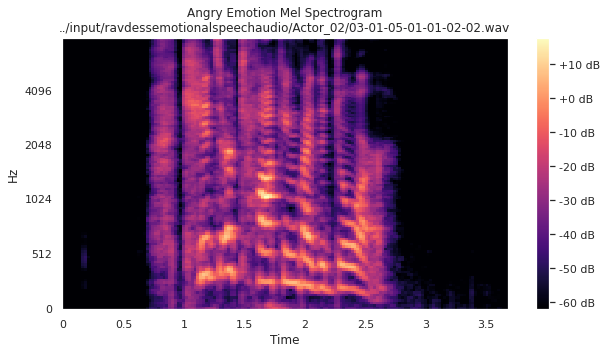

In [26]:
def mel_spectogram(audio_time_series, sampling_rate, emotion_class, file_path):
    spectrogram = librosa.feature.melspectrogram(y = audio_time_series, sr = sampling_rate, n_mels = 128,fmax = 8000) 
    spectrogram = librosa.power_to_db(spectrogram)
    plt.figure(figsize = (10, 5))
    plt.title(f'{emotion_class.capitalize()} Emotion Mel Spectrogram\n{file_path}')
    librosa.display.specshow(spectrogram, fmax = 8000, x_axis = 'time',y_axis = 'mel')
    plt.colorbar(format = '%+2.0f dB')


audio_path = []
for emotion_class in emotions_classes:
    file_path = np.array(comb_df['location'][comb_df['emotion'] == emotion_class])[0]
    audio_time_series, sampling_rate = librosa.load(file_path)
    mel_spectogram(audio_time_series, sampling_rate, emotion_class, file_path)
    audio_path.append(file_path)


## 1.19 Play The Sound File For Each Of The Emotions Above To Make Sure Sound Files Are Valid And Match The Waveform, Spectogram, and Mel Spectrogram Above.


In [27]:
print('emotions_classes =', emotions_classes,'\n')

for i in range(len(emotions_classes) - 1):
        print(emotions_classes[i].capitalize(), 'Audio Sample\n')
        print(audio_path[i])
        IPython.display.display(IPython.display.Audio(audio_path[i]))


emotions_classes = ['surprise' 'neutral' 'disgust' 'fear' 'sad' 'calm' 'happy' 'angry'] 

Surprise Audio Sample

../input/ravdessemotionalspeechaudio/Actor_02/03-01-08-01-01-01-02.wav


Neutral Audio Sample

../input/ravdessemotionalspeechaudio/Actor_02/03-01-01-01-01-01-02.wav


Disgust Audio Sample

../input/ravdessemotionalspeechaudio/Actor_02/03-01-07-02-01-02-02.wav


Fear Audio Sample

../input/ravdessemotionalspeechaudio/Actor_02/03-01-06-02-02-01-02.wav


Sad Audio Sample

../input/ravdessemotionalspeechaudio/Actor_02/03-01-04-01-02-01-02.wav


Calm Audio Sample

../input/ravdessemotionalspeechaudio/Actor_02/03-01-02-01-01-02-02.wav


Happy Audio Sample

../input/ravdessemotionalspeechaudio/Actor_02/03-01-03-01-01-01-02.wav


___
## #2 Select and Engineer Features


## 2.1 Audio Data Augmentation
> 1. Noise Injection
> 2. Shifting
> 3. Pitching
> 4. Stretching


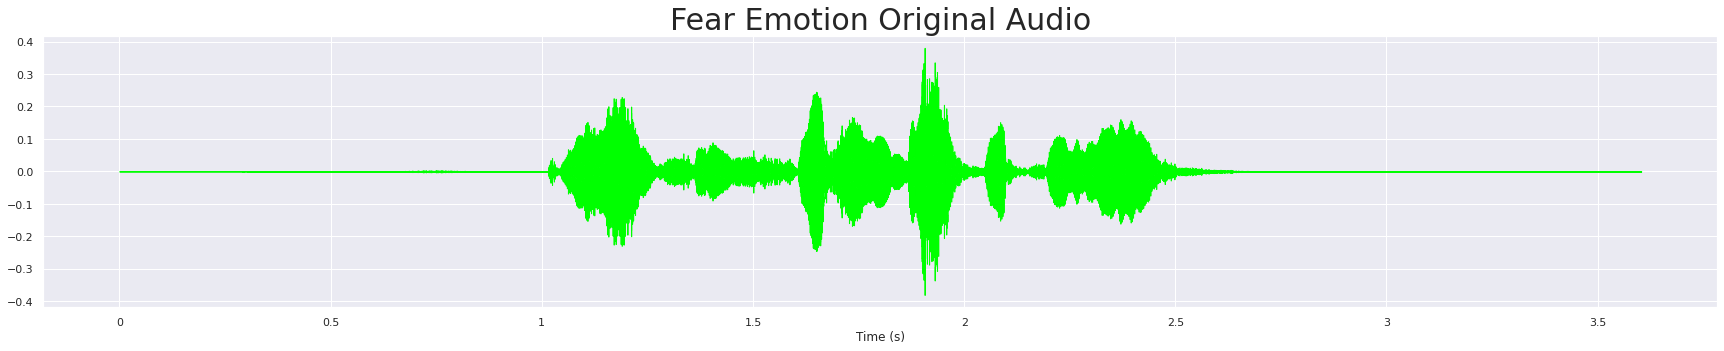

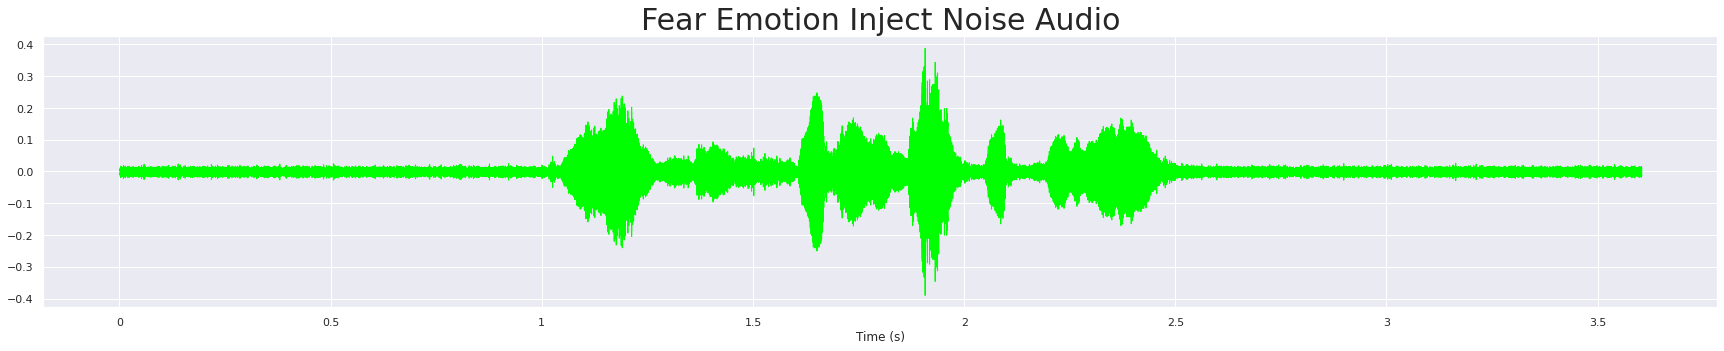

In [28]:
# Noise Injection
def inject_noise(data, random = False, rate = 0.035, threshold = 0.075):
    if random:
        rate = np.random.random() * threshold
    noise_amplitude = rate * np.random.uniform() * np.amax(data)
    augmented_data = data + noise_amplitude * np.random.normal(size = data.shape[0])
    return augmented_data


# Test audio file (fear emotion)
data, sampling_rate = librosa.load(audio_path[3])

IPython.display.display(IPython.display.Audio(audio_path[3]))

plt.figure(figsize = (30,5))
librosa.display.waveshow(data, sampling_rate, color = '#00ff00', x_axis = 's')
plt.title('Fear Emotion Original Audio', size = 30)

noise_audio = inject_noise(data)
plt.figure(figsize = (30,5))
librosa.display.waveshow(noise_audio, sampling_rate, color = '#00ff00', x_axis = 's')
plt.title('Fear Emotion Inject Noise Audio', size = 30)
plt.show()
IPython.display.display(IPython.display.Audio(noise_audio, rate = sampling_rate))


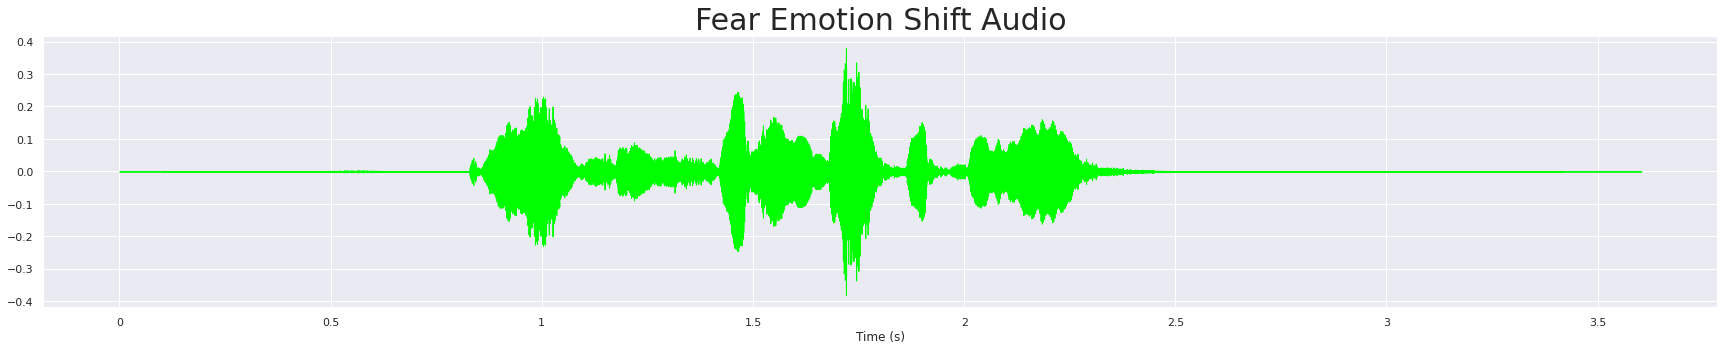

In [29]:
# Shifting
def shifting(data, rate = 1000):
    shift_range = int(np.random.uniform(low = -5, high = 5) * rate)
    shift_range = np.roll(data, shift_range)
    return shift_range

# Test audio file (fear emotion)
shift_audio = shifting(data)
plt.figure(figsize = (30,5))
librosa.display.waveshow(shift_audio, sampling_rate, color = '#00ff00', x_axis = 's')
plt.title('Fear Emotion Shift Audio', size = 30)
plt.show()
IPython.display.display(IPython.display.Audio(shift_audio, rate = sampling_rate))


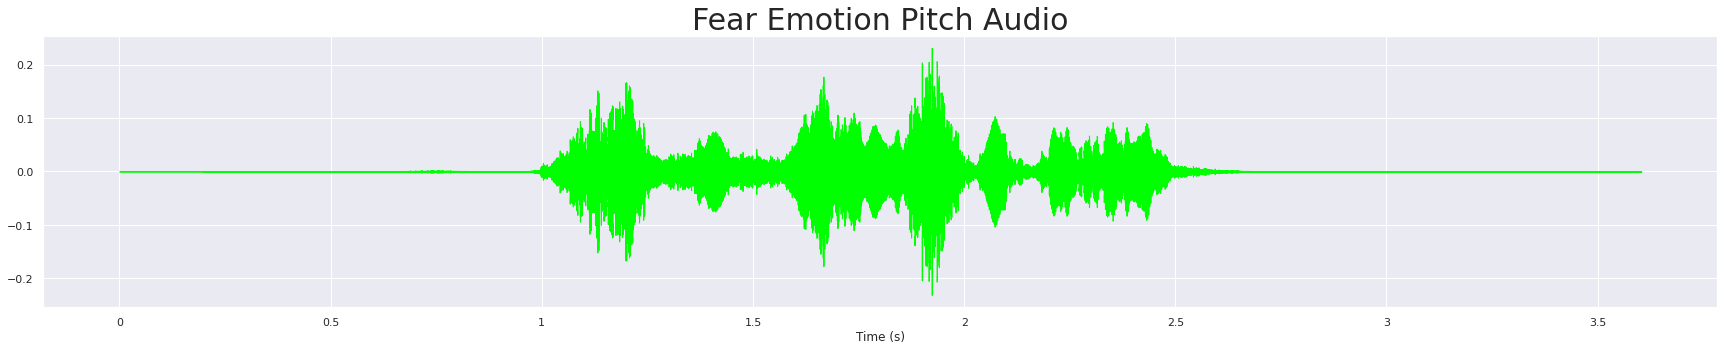

In [30]:
# Pitching
def pitching(data, sampling_rate, pitch_factor = 0.7,random = False):
    if random:
        pitch_factor= np.random.random() * pitch_factor
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)


# Test audio file (fear emotion)
pitch_audio = pitching(data, sampling_rate)
plt.figure(figsize = (30,5))
librosa.display.waveshow(pitch_audio, sampling_rate, color = '#00ff00', x_axis = 's')
plt.title('Fear Emotion Pitch Audio', size = 30)
plt.show()
IPython.display.display(IPython.display.Audio(pitch_audio, rate = sampling_rate))


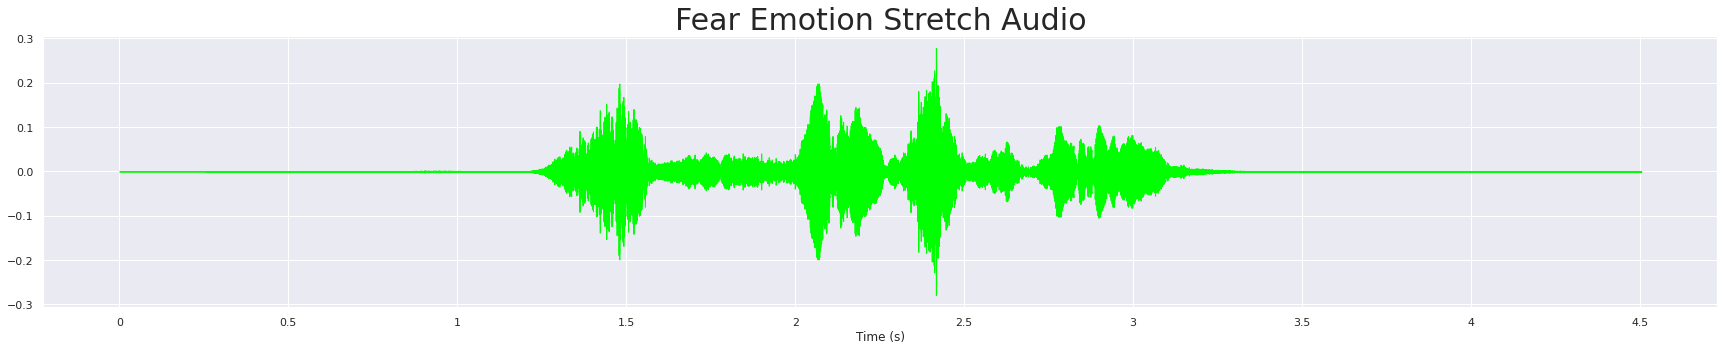

In [31]:
# Stretching
def streching(data,rate = 0.8):
    return librosa.effects.time_stretch(data, rate)


# Test audio file (fear emotion)
stretch_audio = streching(data)
plt.figure(figsize = (30,5))
librosa.display.waveshow(stretch_audio, sampling_rate, color = '#00ff00', x_axis = 's')
plt.title('Fear Emotion Stretch Audio', size = 30)
plt.show()
IPython.display.display(IPython.display.Audio(stretch_audio, rate = sampling_rate))


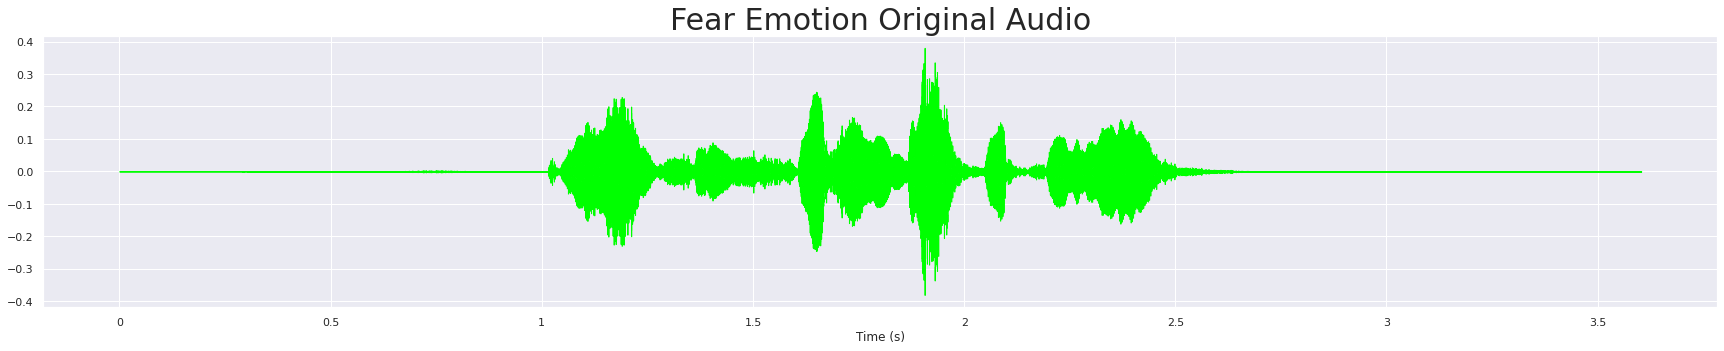

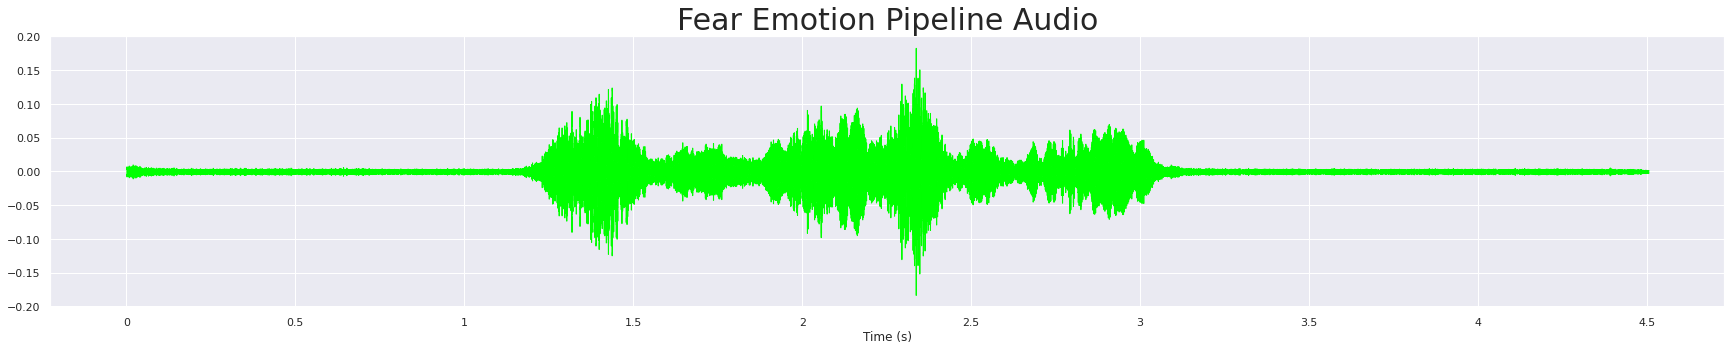

In [32]:
# Pipeline function that applies all the audio data augmentation functions we just built.
def pipeline(data, sampling_rate):
    data = inject_noise(data)
    data = shifting(data)
    data = pitching(data, sampling_rate)
    data = streching(data)
    return data

# Test audio file (fear emotion)
data, sampling_rate = librosa.load(audio_path[3])

IPython.display.display(IPython.display.Audio(audio_path[3]))

plt.figure(figsize = (30,5))
librosa.display.waveshow(data, sampling_rate, color = '#00ff00', x_axis = 's')
plt.title('Fear Emotion Original Audio', size = 30)

pipeline_audio = pipeline(data, sampling_rate)
plt.figure(figsize = (30,5))
librosa.display.waveshow(pipeline_audio, sampling_rate, color = '#00ff00', x_axis = 's')
plt.title('Fear Emotion Pipeline Audio', size = 30)
plt.show()
IPython.display.display(IPython.display.Audio(pipeline_audio, rate = sampling_rate))


## 2.2 Audio Data Feature Extraction
> 1. __Zero Crossing Rate:__
> 2. __Root Mean Square:__
> 3. __Mel Frequency Cepstral Coefficients:__

// __TODO__ if model is not accurate enough.

> 4. __Energy:__ The sum of squares of the signal values, normalized by the respective frame length.
> 5. __Entropy of Energy:__ The entropy of sub-frames’ normalized energies. It can be interpreted as a measure of abrupt changes.
> 6. __Spectral Centroid:__ The center of gravity of the spectrum.
> 7. __Spectral Spread:__ The second central moment of the spectrum.
> 9. __Spectral Entropy:__ Entropy of the normalized spectral energies for a set of sub-frames.
> 9. __Spectral Flux:__ The squared difference between the normalized magnitudes of the spectra of the two successive frames.
> 10. __Spectral Rolloff:__ The frequency below which 90% of the magnitude distribution of the spectrum is concentrated.


In [33]:
def zero_crossing_rate(data,frame_length, hop_length):
    zcr = librosa.feature.zero_crossing_rate(y = data, frame_length = frame_length, hop_length = hop_length)
    return np.squeeze(zcr)

def root_mean_square(data, frame_length = 2048, hop_length = 512):
    rms = librosa.feature.rms(y = data, frame_length = frame_length, hop_length = hop_length)
    return np.squeeze(rms)

def mel_frequency_cepstral_coefficients(data, sampling_rate, frame_length = 2048, hop_length = 512, flatten:bool = True):
    mfcc = librosa.feature.mfcc(y = data,sr = sampling_rate)
    return np.squeeze(mfcc.T) if not flatten else np.ravel(mfcc.T)


In [34]:
def feature_extraction(data, sampling_rate, frame_length = 2048, hop_length = 512):
    result = np.array([])
    
    result = np.hstack((result,
                      zero_crossing_rate(data, frame_length, hop_length),
                      root_mean_square(data, frame_length, hop_length),
                      mel_frequency_cepstral_coefficients(data, sampling_rate, frame_length, hop_length)
                     ))
    return result


In [35]:
#  duration and offset act as placeholders because there is no audio in start and the ending of each audio file is noramlly below three seconds.
def get_features(file_path, duration = 2.5, offset = 0.6):
    data, sampling_rate = librosa.load(file_path, duration = duration, offset = offset)
    
    # No audio data augmentation
    audio_1 = feature_extraction(data, sampling_rate)
    audio = np.array(audio_1)
    
    # Inject Noise
    noise_audio = inject_noise(data, random = True)
    audio_2 =  feature_extraction(noise_audio, sampling_rate)
    audio = np.vstack((audio, audio_2))
    
    # Pitching
    pitch_audio = pitching(data, sampling_rate, random = True)
    audio_3 = feature_extraction(pitch_audio, sampling_rate)
    audio = np.vstack((audio, audio_3))
    
    # Pitching and Inject Noise
    pitch_audio_1 = pitching(data, sampling_rate, random = True)
    pitch_noise_audio = inject_noise(pitch_audio_1, random = True)
    audio_4 = feature_extraction(pitch_noise_audio, sampling_rate)
    audio = np.vstack((audio, audio_4))
    
    audio_features = audio
    
    return audio


## 2.3 Extract Audio Data Features From Each Audio File


In [36]:
features_list = []
genders_list = []
emotions_list = []
locations_list = []

print('Audio Data - Features Extraction Starts')

for gender, emotion, file_path, index in zip(comb_df.gender, comb_df.emotion, comb_df.location, tqdm(range(comb_df.location.shape[0]))):
    features = get_features(file_path)    
    
    if index % 1 == 0:
        print(index, ' audio files have been feature extracted(', round(index / 12162 * 100), '%)\r', sep = '', end = '')
    
    for i in features:
        features_list.append(i)
        genders_list.append(gender)
        emotions_list.append(emotion)
        locations_list.append(file_path)


print('Audio Data - Features Extraction Ends')


Audio Data - Features Extraction Starts


  0%|          | 0/12162 [00:00<?, ?it/s]

Audio Data - Features Extraction Endsxtracted(100%)


## 2.4 Convert The Audio Data Features From Each Audio File To A Dataframe.


In [37]:
audio_features_df = pd.DataFrame(features_list)
audio_features_df['gender'] = genders_list
audio_features_df['emotion'] = emotions_list
audio_features_df['location'] = locations_list


In [38]:
print('audio_features_df.shape =', audio_features_df.shape, '\n')

print(audio_features_df.isnull().sum(), '\n')
print('audio_features_df.isnull().sum().sum() = ', audio_features_df.isnull().sum().sum())

print('audio_features_df.duplicated().sum() = ', audio_features_df.duplicated().sum())


audio_features_df


audio_features_df.shape = (48648, 2379) 

0               0
1               0
2               0
3               0
4               0
            ...  
2374        37624
2375        37624
gender          0
emotion         0
location        0
Length: 2379, dtype: int64 

audio_features_df.isnull().sum().sum() =  28245624
audio_features_df.duplicated().sum() =  2


0         1         2         3         4         5         6  \
0      0.331543  0.471680  0.564941  0.452148  0.374512  0.296875  0.265137   
1      0.243164  0.371094  0.484375  0.485352  0.480957  0.469727  0.479492   
2      0.296875  0.421387  0.520020  0.444824  0.368164  0.312500  0.275391   
3      0.247070  0.367188  0.484863  0.475098  0.446777  0.417480  0.390625   
4      0.400879  0.591309  0.783203  0.777832  0.771973  0.777832  0.771973   
...         ...       ...       ...       ...       ...       ...       ...   
48643  0.046875  0.066895  0.085938  0.072266  0.062500  0.066406  0.079590   
48644  0.042480  0.059570  0.069336  0.058594  0.038086  0.026367  0.027344   
48645  0.043457  0.064453  0.084961  0.083008  0.067383  0.057617  0.062500   
48646  0.046387  0.062500  0.073242  0.064453  0.041504  0.033691  0.033203   
48647  0.050781  0.068848  0.079590  0.071289  0.044434  0.035645  0.035645   

              7         8         9  ...      2369      2370      2371  \
0      0.256348  0.252441  0.251953  ... -1.599245 -1.234544 -0.693115   
1      0.473145  0.486328  0.490234  ... -1.304745 -4.717040 -0.438688   
2      0.263672  0.256348  0.250000  ... -0.178314  0.522394  0.905293   
3      0.371094  0.373047  0.379883  ...  3.928558 -0.497338  5.420446   
4      0.775391  0.758789  0.580078  ...  2.223155  0.986784 -0.730886   
...         ...       ...       ...  ...       ...       ...       ...   
48643  0.099609  0.113770  0.110840  ...       NaN       NaN       NaN   
48644  0.031250  0.037109  0.041992  ...       NaN       NaN       NaN   
48645  0.062500  0.065430  0.064453  ...       NaN       NaN       NaN   
48646  0.034180  0.039551  0.041504  ...       NaN       NaN       NaN   
48647  0.035645  0.041016  0.043457  ...       NaN       NaN       NaN   

           2372      2373      2374      2375  gender   emotion  \
0     -0.038821  0.675410  1.405862  2.112551  female  surprise   
1      6.393335  3.188480 -3.560567 -4.162283  female  surprise   
2      0.916326  0.685271  0.471279  0.545819  female  surprise   
3      4.564843  0.168735  0.187176 -3.505306  female  surprise   
4     -2.531058 -4.002848 -4.849192 -4.929412  female   neutral   
...         ...       ...       ...       ...     ...       ...   
48643       NaN       NaN       NaN       NaN  female  surprise   
48644       NaN       NaN       NaN       NaN  female  surprise   
48645       NaN       NaN       NaN       NaN  female  surprise   
48646       NaN       NaN       NaN       NaN  female  surprise   
48647       NaN       NaN       NaN       NaN  female  surprise   

                                                location  
0      ../input/ravdessemotionalspeechaudio/Actor_02/...  
1      ../input/ravdessemotionalspeechaudio/Actor_02/...  
2      ../input/ravdessemotionalspeechaudio/Actor_02/...  
3      ../input/ravdessemotionalspeechaudio/Actor_02/...  
4      ../input/ravdessemotionalspeechaudio/Actor_02/...  
...                                                  ...  
48643  ../input/torontoemotionalspeechsettess/YAF_ple...  
48644  ../input/torontoemotionalspeechsettess/YAF_ple...  
48645  ../input/torontoemotionalspeechsettess/YAF_ple...  
48646  ../input/torontoemotionalspeechsettess/YAF_ple...  
48647  ../input/torontoemotionalspeechsettess/YAF_ple...  

[48648 rows x 2379 columns]

## 2.4 Convert The Audio Data Features From Each Audio File To A .csv File For Future Reference So That We Can Load It Without Doing The Feature Extraction Again.


In [39]:
audio_features_df.to_csv('./audio_features.csv', index = False)


In [40]:
# This is used to load the .csv file into the audio_features_df whenever necessary.
#audio_features_df = pd.read_csv('../working/audio_features.csv')


## 2.5 Inspect / Replace null Values


In [41]:
print('audio_features_df.shape =', audio_features_df.shape, '\n')
print('audio_features_df.isna().sum().sum() =', audio_features_df.isna().sum().sum(), '\n')
print(audio_features_df.isna().any())
print()
audio_features_df.isnull().sum(axis = 0)

print('Replacing NaN values with 0.\n')
audio_features_df = audio_features_df.fillna(0)

print('audio_features_df.shape =', audio_features_df.shape, '\n')
print('audio_features_df.isna().sum().sum() =', audio_features_df.isna().sum().sum(), '\n')
print(audio_features_df.isna().any())
print()
audio_features_df.isnull().sum(axis = 0)


audio_features_df.shape = (48648, 2379) 

audio_features_df.isna().sum().sum() = 28245624 

0           False
1           False
2           False
3           False
4           False
            ...  
2374         True
2375         True
gender      False
emotion     False
location    False
Length: 2379, dtype: bool

Replacing NaN values with 0.

audio_features_df.shape = (48648, 2379) 

audio_features_df.isna().sum().sum() = 0 

0           False
1           False
2           False
3           False
4           False
            ...  
2374        False
2375        False
gender      False
emotion     False
location    False
Length: 2379, dtype: bool



0           0
1           0
2           0
3           0
4           0
           ..
2374        0
2375        0
gender      0
emotion     0
location    0
Length: 2379, dtype: int64

## 2.6 Inspect/ Remove Duplicate Rows

In [42]:
print('audio_features_df.duplicated().sum() = ', audio_features_df.duplicated().sum())

duplicate = audio_features_df[audio_features_df.duplicated()]

print('Duplicate Rows:')

duplicate


audio_features_df.duplicated().sum() =  2
Duplicate Rows:


0    1    2    3    4    5    6    7    8    9  ...  2369  2370  \
32458  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   
32459  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   

       2371  2372  2373  2374  2375  gender  emotion  \
32458   0.0   0.0   0.0   0.0   0.0  female      sad   
32459   0.0   0.0   0.0   0.0   0.0  female      sad   

                                            location  
32458  ../input/cremad/AudioWAV//1076_MTI_SAD_XX.wav  
32459  ../input/cremad/AudioWAV//1076_MTI_SAD_XX.wav  

[2 rows x 2379 columns]

### Four Times More Rows Than The Original/Initial Dataset Because For Each Audio File We Now Have Four Rows Representing:
1. No Audio Data Augmentation (first row)
2. Inject Noise (second row)
3. Pitching (third row)
4. Pitching and Inject Noise (fourth row)


In [43]:
print('audio_features_df.shape =', audio_features_df.shape)

audio_features_df = audio_features_df.drop_duplicates()

print('audio_features_df.duplicated().sum() =', audio_features_df.duplicated().sum())

print('audio_features_df.shape =', audio_features_df.shape)

audio_features_df


audio_features_df.shape = (48648, 2379)
audio_features_df.duplicated().sum() = 0
audio_features_df.shape = (48646, 2379)


0         1         2         3         4         5         6  \
0      0.331543  0.471680  0.564941  0.452148  0.374512  0.296875  0.265137   
1      0.243164  0.371094  0.484375  0.485352  0.480957  0.469727  0.479492   
2      0.296875  0.421387  0.520020  0.444824  0.368164  0.312500  0.275391   
3      0.247070  0.367188  0.484863  0.475098  0.446777  0.417480  0.390625   
4      0.400879  0.591309  0.783203  0.777832  0.771973  0.777832  0.771973   
...         ...       ...       ...       ...       ...       ...       ...   
48643  0.046875  0.066895  0.085938  0.072266  0.062500  0.066406  0.079590   
48644  0.042480  0.059570  0.069336  0.058594  0.038086  0.026367  0.027344   
48645  0.043457  0.064453  0.084961  0.083008  0.067383  0.057617  0.062500   
48646  0.046387  0.062500  0.073242  0.064453  0.041504  0.033691  0.033203   
48647  0.050781  0.068848  0.079590  0.071289  0.044434  0.035645  0.035645   

              7         8         9  ...      2369      2370      2371  \
0      0.256348  0.252441  0.251953  ... -1.599245 -1.234544 -0.693115   
1      0.473145  0.486328  0.490234  ... -1.304745 -4.717040 -0.438688   
2      0.263672  0.256348  0.250000  ... -0.178314  0.522394  0.905293   
3      0.371094  0.373047  0.379883  ...  3.928558 -0.497338  5.420446   
4      0.775391  0.758789  0.580078  ...  2.223155  0.986784 -0.730886   
...         ...       ...       ...  ...       ...       ...       ...   
48643  0.099609  0.113770  0.110840  ...  0.000000  0.000000  0.000000   
48644  0.031250  0.037109  0.041992  ...  0.000000  0.000000  0.000000   
48645  0.062500  0.065430  0.064453  ...  0.000000  0.000000  0.000000   
48646  0.034180  0.039551  0.041504  ...  0.000000  0.000000  0.000000   
48647  0.035645  0.041016  0.043457  ...  0.000000  0.000000  0.000000   

           2372      2373      2374      2375  gender   emotion  \
0     -0.038821  0.675410  1.405862  2.112551  female  surprise   
1      6.393335  3.188480 -3.560567 -4.162283  female  surprise   
2      0.916326  0.685271  0.471279  0.545819  female  surprise   
3      4.564843  0.168735  0.187176 -3.505306  female  surprise   
4     -2.531058 -4.002848 -4.849192 -4.929412  female   neutral   
...         ...       ...       ...       ...     ...       ...   
48643  0.000000  0.000000  0.000000  0.000000  female  surprise   
48644  0.000000  0.000000  0.000000  0.000000  female  surprise   
48645  0.000000  0.000000  0.000000  0.000000  female  surprise   
48646  0.000000  0.000000  0.000000  0.000000  female  surprise   
48647  0.000000  0.000000  0.000000  0.000000  female  surprise   

                                                location  
0      ../input/ravdessemotionalspeechaudio/Actor_02/...  
1      ../input/ravdessemotionalspeechaudio/Actor_02/...  
2      ../input/ravdessemotionalspeechaudio/Actor_02/...  
3      ../input/ravdessemotionalspeechaudio/Actor_02/...  
4      ../input/ravdessemotionalspeechaudio/Actor_02/...  
...                                                  ...  
48643  ../input/torontoemotionalspeechsettess/YAF_ple...  
48644  ../input/torontoemotionalspeechsettess/YAF_ple...  
48645  ../input/torontoemotionalspeechsettess/YAF_ple...  
48646  ../input/torontoemotionalspeechsettess/YAF_ple...  
48647  ../input/torontoemotionalspeechsettess/YAF_ple...  

[48646 rows x 2379 columns]

## 2.7 Print Out The Number Examples In Each Class (aka the class balances)


In [44]:
audio_features_df.emotion.value_counts(), audio_features_df.emotion.value_counts(normalize = True)


(disgust     7692
 fear        7692
 happy       7692
 angry       7692
 sad         7690
 neutral     6812
 surprise    2608
 calm         768
 Name: emotion, dtype: int64,
 disgust     0.158122
 fear        0.158122
 happy       0.158122
 angry       0.158122
 sad         0.158081
 neutral     0.140032
 surprise    0.053612
 calm        0.015788
 Name: emotion, dtype: float64)

## 2.8 Print Out The Number Of Unique Emotions


In [45]:
emotions_classes = audio_features_df['emotion'].unique()
print(emotions_classes)


['surprise' 'neutral' 'disgust' 'fear' 'sad' 'calm' 'happy' 'angry']


## 2.9 Split Our Data Into Training (80%), Validating (10%), and Testing (10%) Sets


In [46]:
X = audio_features_df.drop(labels = ['emotion', 'gender', 'location'], axis = 1)
y = audio_features_df['emotion']


In [47]:
X

0         1         2         3         4         5         6     \
0      0.331543  0.471680  0.564941  0.452148  0.374512  0.296875  0.265137   
1      0.243164  0.371094  0.484375  0.485352  0.480957  0.469727  0.479492   
2      0.296875  0.421387  0.520020  0.444824  0.368164  0.312500  0.275391   
3      0.247070  0.367188  0.484863  0.475098  0.446777  0.417480  0.390625   
4      0.400879  0.591309  0.783203  0.777832  0.771973  0.777832  0.771973   
...         ...       ...       ...       ...       ...       ...       ...   
48643  0.046875  0.066895  0.085938  0.072266  0.062500  0.066406  0.079590   
48644  0.042480  0.059570  0.069336  0.058594  0.038086  0.026367  0.027344   
48645  0.043457  0.064453  0.084961  0.083008  0.067383  0.057617  0.062500   
48646  0.046387  0.062500  0.073242  0.064453  0.041504  0.033691  0.033203   
48647  0.050781  0.068848  0.079590  0.071289  0.044434  0.035645  0.035645   

           7         8         9     ...      2366      2367      2368  \
0      0.256348  0.252441  0.251953  ... -0.948772 -1.517647 -1.716411   
1      0.473145  0.486328  0.490234  ... -2.766196  4.632407  2.586598   
2      0.263672  0.256348  0.250000  ... -1.888798 -1.638189 -0.988863   
3      0.371094  0.373047  0.379883  ...  1.395438  4.425796  2.975887   
4      0.775391  0.758789  0.580078  ...  2.004560  2.585884  2.746578   
...         ...       ...       ...  ...       ...       ...       ...   
48643  0.099609  0.113770  0.110840  ...  0.000000  0.000000  0.000000   
48644  0.031250  0.037109  0.041992  ...  0.000000  0.000000  0.000000   
48645  0.062500  0.065430  0.064453  ...  0.000000  0.000000  0.000000   
48646  0.034180  0.039551  0.041504  ...  0.000000  0.000000  0.000000   
48647  0.035645  0.041016  0.043457  ...  0.000000  0.000000  0.000000   

           2369      2370      2371      2372      2373      2374      2375  
0     -1.599245 -1.234544 -0.693115 -0.038821  0.675410  1.405862  2.112551  
1     -1.304745 -4.717040 -0.438688  6.393335  3.188480 -3.560567 -4.162283  
2     -0.178314  0.522394  0.905293  0.916326  0.685271  0.471279  0.545819  
3      3.928558 -0.497338  5.420446  4.564843  0.168735  0.187176 -3.505306  
4      2.223155  0.986784 -0.730886 -2.531058 -4.002848 -4.849192 -4.929412  
...         ...       ...       ...       ...       ...       ...       ...  
48643  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
48644  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
48645  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
48646  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
48647  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  

[48646 rows x 2376 columns]

In [48]:
y

0        surprise
1        surprise
2        surprise
3        surprise
4         neutral
           ...   
48643    surprise
48644    surprise
48645    surprise
48646    surprise
48647    surprise
Name: emotion, Length: 48646, dtype: object

In [49]:
label = LabelEncoder()

y = np_utils.to_categorical(label.fit_transform(y))

print(label.classes_)

y


['angry' 'calm' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']


array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [50]:
X_train, X_remain, y_train, y_remain = train_test_split(
    X, y, test_size = 0.2, random_state = 42)

print('X_remain.shape = ', X_remain.shape)
print('y_remain.shape = ', y_remain.shape)

X_valid, X_test, y_valid, y_test = train_test_split(
    X_remain, y_remain, test_size = 0.5, random_state = 42)

print('X_train.shape = ', X_train.shape)
print('y_train.shape = ', y_train.shape)
print('X_valid.shape = ', X_valid.shape)
print('y_valid.shape = ', y_valid.shape)
print('X_test.shape  = ', X_test.shape)
print('y_test.shape  = ', y_test.shape)


X_remain.shape =  (9730, 2376)
y_remain.shape =  (9730, 8)
X_train.shape =  (38916, 2376)
y_train.shape =  (38916, 8)
X_valid.shape =  (4865, 2376)
y_valid.shape =  (4865, 8)
X_test.shape  =  (4865, 2376)
y_test.shape  =  (4865, 8)


In [51]:
# Standardize / Scale data
# Standardize features by removing the mean and scaling to unit variance.
# z = (x - u) / s

standard_scaler = StandardScaler()
X_train = standard_scaler.fit_transform(X_train)
X_valid = standard_scaler.transform(X_valid)
X_test = standard_scaler.transform(X_test)

print('X_train.shape = ', X_train.shape)
print('X_remain.shape = ', X_remain.shape)
print('X_valid.shape = ', X_valid.shape)
print('X_test.shape  = ', X_test.shape)


X_train.shape =  (38916, 2376)
X_remain.shape =  (9730, 2376)
X_valid.shape =  (4865, 2376)
X_test.shape  =  (4865, 2376)


In [52]:
# Modify data to fit into a 1D-CNN

X_train = np.expand_dims(X_train, axis = 2)
X_valid = np.expand_dims(X_valid, axis = 2)
X_test = np.expand_dims(X_test, axis = 2)

print('X_train.shape = ', X_train.shape)
print('X_remain.shape = ', X_remain.shape)
print('X_valid.shape = ', X_valid.shape)
print('X_test.shape  = ', X_test.shape)


X_train.shape =  (38916, 2376, 1)
X_remain.shape =  (9730, 2376)
X_valid.shape =  (4865, 2376, 1)
X_test.shape  =  (4865, 2376, 1)


In [53]:
print('X_train.shape', X_train.shape)
print('X_valid.shape', X_valid.shape)
print('X_test.shape', X_test.shape)

print('y_train.shape', y_train.shape)
print('y_valid.shape', y_valid.shape)
print('y_test.shape', y_test.shape)

X_train.shape (38916, 2376, 1)
X_valid.shape (4865, 2376, 1)
X_test.shape (4865, 2376, 1)
y_train.shape (38916, 8)
y_valid.shape (4865, 8)
y_test.shape (4865, 8)


____
## #3 Build and Train Model


## 3.1 Build / Define The Model
### __Create The Neural Netowrk__


In [54]:
early_stopping = EarlyStopping(monitor = 'val_accuracy',
                               patience = 10,
                               mode = 'auto',
                               restore_best_weights = True)


In [55]:
reduce_learning_rate = ReduceLROnPlateau(monitor ='val_accuracy',
                                            factor = 0.5,
                                            verbose = 1,
                                            min_lr = 0.00001)


In [56]:
# Create the neural netowrk

model = models.Sequential()

model.add(layers.Conv1D(filters = 512, kernel_size = 5, strides = 1, padding = 'same', activation = 'relu', input_shape = (X_train.shape[1], 1)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool1D(pool_size = 5, strides = 2, padding = 'same'))

model.add(layers.Conv1D(filters = 512, kernel_size = 5, strides = 1, padding = 'same', activation = 'relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool1D(pool_size = 5, strides = 2, padding = 'same'))

model.add(layers.Conv1D(filters = 256, kernel_size = 5, strides = 1, padding = 'same', activation = 'relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool1D(pool_size = 5, strides = 2, padding = 'same'))

model.add(layers.Conv1D(filters = 256, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling1D(pool_size = 5, strides = 2, padding = 'same'))

model.add(layers.Conv1D(filters = 128, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling1D(pool_size = 3, strides = 2, padding = 'same'))

model.add(layers.Flatten())

model.add(layers.Dense(units = 512, activation = 'relu'))

model.add(layers.BatchNormalization())

model.add(layers.Dense(units = 8, activation = 'softmax'))

model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics=['accuracy'])

print(model.summary())


2022-10-25 21:53:01.493302: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-25 21:53:01.500058: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-25 21:53:01.500928: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-25 21:53:01.503130: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 2376, 512)         3072      
_________________________________________________________________
batch_normalization (BatchNo (None, 2376, 512)         2048      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1188, 512)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1188, 512)         1311232   
_________________________________________________________________
batch_normalization_1 (Batch (None, 1188, 512)         2048      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 594, 512)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 594, 256)          6

## 3.3 Train The Model For A Fixed Number Of Epochs


In [57]:
history_callback_object = model.fit(x = X_train, y = y_train, batch_size = 64, epochs = 50, callbacks = [early_stopping, reduce_learning_rate], validation_data = (X_valid, y_valid))


2022-10-25 21:53:05.371692: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 369857664 exceeds 10% of free system memory.
2022-10-25 21:53:05.979659: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 369857664 exceeds 10% of free system memory.
2022-10-25 21:53:06.424010: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-10-25 21:53:09.403083: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


609/609 [==============================] - ETA: 0s - loss: 1.3852 - accuracy: 0.4825

2022-10-25 21:54:55.267089: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 46236960 exceeds 10% of free system memory.
2022-10-25 21:54:55.343835: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 46236960 exceeds 10% of free system memory.


609/609 [==============================] - 112s 169ms/step - loss: 1.3852 - accuracy: 0.4825 - val_loss: 1.8662 - val_accuracy: 0.3494
Epoch 2/50


2022-10-25 21:54:58.858408: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 19660800 exceeds 10% of free system memory.


609/609 [==============================] - 102s 168ms/step - loss: 1.0931 - accuracy: 0.5787 - val_loss: 1.1905 - val_accuracy: 0.5542
Epoch 3/50
609/609 [==============================] - 102s 168ms/step - loss: 0.9808 - accuracy: 0.6240 - val_loss: 1.0136 - val_accuracy: 0.6162
Epoch 4/50
609/609 [==============================] - 102s 168ms/step - loss: 0.8286 - accuracy: 0.6866 - val_loss: 1.0192 - val_accuracy: 0.6148
Epoch 5/50
609/609 [==============================] - 102s 168ms/step - loss: 0.6844 - accuracy: 0.7426 - val_loss: 0.8906 - val_accuracy: 0.6734
Epoch 6/50
609/609 [==============================] - 102s 168ms/step - loss: 0.5304 - accuracy: 0.8069 - val_loss: 0.7400 - val_accuracy: 0.7320
Epoch 7/50
609/609 [==============================] - 102s 168ms/step - loss: 0.3497 - accuracy: 0.8772 - val_loss: 0.4924 - val_accuracy: 0.8335
Epoch 8/50
609/609 [==============================] - 102s 168ms/step - loss: 0.2084 - accuracy: 0.9305 - val_loss: 0.5365 - val_accura

## 3.4 Save The Model


In [58]:
file_path_model = './model.h5'

model.save(file_path_model)


In [59]:
# This is used to load the model whenever necessary.
#file_path_model = './model.h5'

#loaded_model = load_model(file_path_model)


___
## #4 Evaluate Model


## 4.1 Model Loss Graph


In [60]:
fig = px.line(data_frame = history_callback_object.history,
              y = ['loss', 'val_loss'],
              labels = {'index':'Epoch', 'value':'Loss'},
              title = 'Loss vs Epoch')
fig.show()

history_callback_object.history.keys()


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

## 4.2 Model Accuracy Graph


In [61]:
fig = px.line(data_frame = history_callback_object.history,
              y = ['accuracy', 'val_accuracy'],
              labels = {'index':'Epoch', 'value':'Accuracy'},
              title = 'Accuracy vs Epoch')
fig.show()

history_callback_object.history.keys()


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

## 4.3 Side To Side Model Loss And Accuracy Graphs


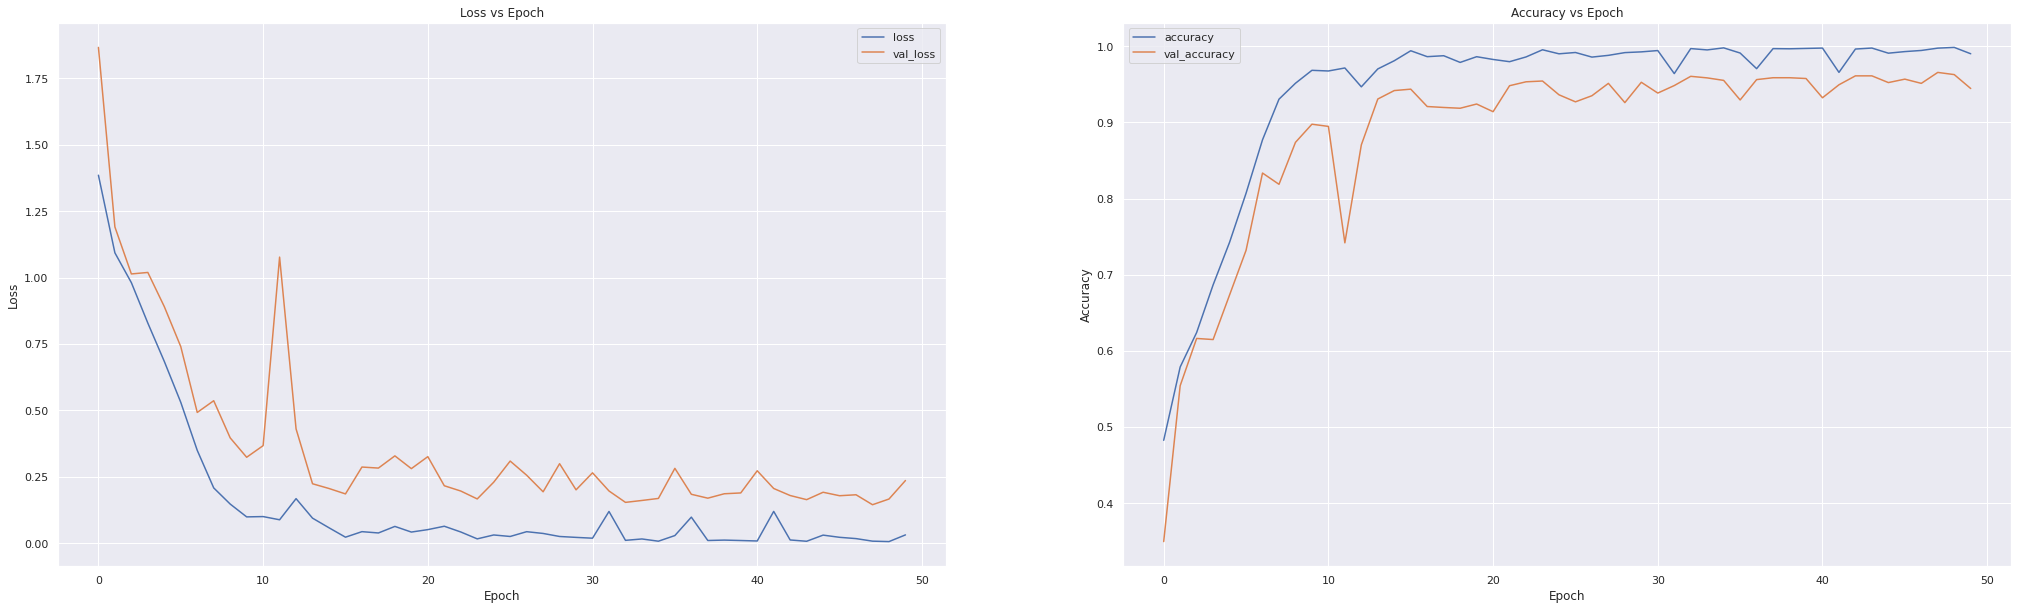

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

In [62]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(history_callback_object.history['loss'], label = 'loss')
ax1.plot(history_callback_object.history['val_loss'], label = 'val_loss')
ax1.legend()
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Loss vs Epoch')
ax1.grid(True)

ax2.plot(history_callback_object.history['accuracy'], label = 'accuracy')
ax2.plot(history_callback_object.history['val_accuracy'], label = 'val_accuracy')
ax2.legend()
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Accuracy vs Epoch')
ax2.grid(True)

fig.set_figheight(10)
fig.set_figwidth(35)
plt.show()

history_callback_object.history.keys()


## 4.4 Make And Evaluate New Predictions Using Our Testing Data


In [63]:
y_pred = model.predict(X_test)
y_pred


array([[1.4222641e-06, 1.4191890e-07, 2.1370033e-07, ..., 2.5299445e-05,
        1.3756729e-06, 3.5394127e-08],
       [9.9198496e-01, 3.3334591e-10, 6.4927343e-07, ..., 8.7672258e-11,
        7.2375506e-10, 1.5219874e-03],
       [1.9158656e-11, 7.2552011e-14, 6.1842510e-12, ..., 7.4560287e-09,
        4.8848492e-10, 2.1334222e-10],
       ...,
       [1.4805199e-10, 1.2016377e-10, 7.0297705e-07, ..., 9.9994993e-01,
        2.9036493e-05, 1.8987022e-10],
       [1.9043918e-17, 2.4865549e-16, 2.1174648e-08, ..., 4.6553842e-13,
        9.9999475e-01, 1.4402437e-17],
       [5.4863394e-06, 5.1908499e-12, 7.5532964e-18, ..., 4.4750039e-09,
        9.7554519e-14, 9.9757439e-01]], dtype=float32)

In [64]:
y_pred = np.argmax(y_pred, axis = 1)
y_pred


array([4, 0, 4, ..., 5, 6, 7])

In [65]:
y_check = np.argmax(y_test, axis = 1)
y_check


array([4, 0, 4, ..., 5, 6, 7])

In [66]:
print('Accuracy of model on test data: ', model.evaluate(X_test, y_test)[1] * 100 , '%', sep = '')


153/153 [==============================] - 4s 24ms/step - loss: 0.2208 - accuracy: 0.9441
Accuracy of model on test data: 94.40904259681702%


In [67]:
model_loss, model_accuracy = model.evaluate(X_test, y_test)

print('Model Test Loss: %f' % (model_loss))
print('Model Test Loss: %f' % (model_loss * 100), '%\n', sep = '')
print('Model Test Accuracy: %f' % (model_accuracy))
print('Model Test Accuracy: %f' % (model_accuracy * 100), '%', sep = '')


153/153 [==============================] - 4s 25ms/step - loss: 0.2208 - accuracy: 0.9441
Model Test Loss: 0.220756
Model Test Loss: 22.075604%

Model Test Accuracy: 0.944090
Model Test Accuracy: 94.409043%


In [68]:
# Calculate our accuracy score.
accuracy = accuracy_score(y_check, y_pred)

# Calculate our precision score.
precision = precision_score(y_check, y_pred, average = 'micro')

# Calculate our recall score.
recall = recall_score(y_check, y_pred, average = 'micro')

# Calculate your f1-score.
f1 = f1_score(y_check, y_pred, average = 'micro')

# Print each of our scores to inspect performance.
print('Accuracy Score: %f' % (accuracy * 100), '%', sep = '')
print('Precision Score: %f' % (precision * 100), '%', sep = '')
print('Recall Score: %f' % (recall * 100), '%', sep = '')
print('F1 Score: %f' % (f1 * 100), '%', sep = '')


Accuracy Score: 94.409044%
Precision Score: 94.409044%
Recall Score: 94.409044%
F1 Score: 94.409044%


## 4.5 Confusion Matrix


[[[4085   25]
  [  50  705]]

 [[4785    2]
  [   2   76]]

 [[4028   34]
  [  52  751]]

 [[4015   73]
  [  46  731]]

 [[4005   54]
  [  45  761]]

 [[4170   39]
  [  37  619]]

 [[4102   33]
  [  36  694]]

 [[4593   12]
  [   4  256]]] 



          surprise  neutral  disgust  fear  sad  calm  happy  angry
surprise       705        0       11    19   13     5      0      2
neutral          0       76        0     1    0     1      0      0
disgust          5        0      751    14   12     9     10      2
fear             8        0        3   731   11     9     11      4
sad             10        0        2    20  761     8      3      2
calm             0        2       10     6    8   619      9      2
happy            1        0        7    13    8     7    694      0
angry            1        0        1     0    2     0      0    256 





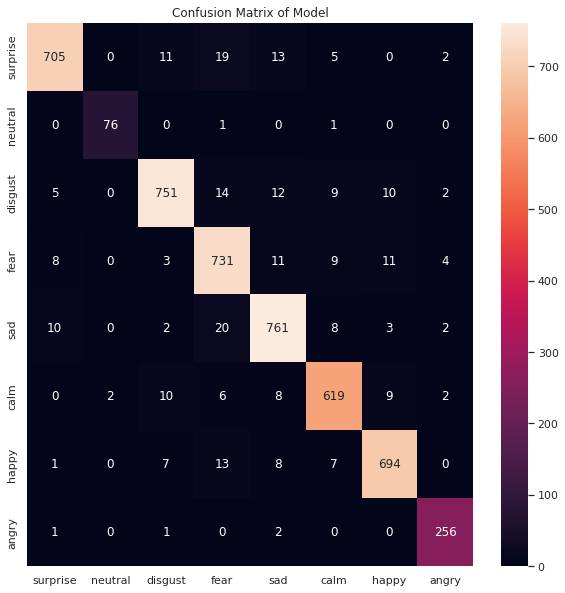

In [69]:
fig = plt.figure(figsize=(10, 10))
plt.title('Confusion Matrix of Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')

cm = multilabel_confusion_matrix(y_check, y_pred)
print(cm, '\n\n\n')

model_matrix = confusion_matrix(y_check, y_pred)
cm = pd.DataFrame(model_matrix,
                  index = [i for i in emotions_classes],
                  columns = [i for i in emotions_classes]
                 )


ax = sns.heatmap(cm,
                 annot = True,
                 fmt = 'd',cbar=True)

print(cm, '\n\n\n')

plt.show()


## 4.6 Classification Report


In [70]:
print('Model Classification Report\n', classification_report(y_check, y_pred, target_names = emotions_classes))


Model Classification Report
               precision    recall  f1-score   support

    surprise       0.97      0.93      0.95       755
     neutral       0.97      0.97      0.97        78
     disgust       0.96      0.94      0.95       803
        fear       0.91      0.94      0.92       777
         sad       0.93      0.94      0.94       806
        calm       0.94      0.94      0.94       656
       happy       0.95      0.95      0.95       730
       angry       0.96      0.98      0.97       260

    accuracy                           0.94      4865
   macro avg       0.95      0.95      0.95      4865
weighted avg       0.94      0.94      0.94      4865

